# Distance - KPI

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import math
from matplotlib.dates import date2num
import random
import timeit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

In [2]:
#sns.set_theme(style="white", context="talk")

# Data Reading

In [3]:
def read_data(city_name):
    trip_data = pd.read_csv("Project_Data/Combined_Data/"+city_name+".csv", encoding = "ISO-8859-1")
    trip_data["trip_duration"] = pd.to_timedelta(trip_data["trip_duration"])
    trip_data["datetime_start"] = pd.to_datetime(trip_data["datetime_start"])
    trip_data["datetime_end"] = pd.to_datetime(trip_data["datetime_end"])
    trip_data["day"] = pd.to_datetime(trip_data["day"])
    return trip_data

# KPI generation

### Description of KPI
The kpi "distance" refers to the average distance travelled per tour for a given time period and  is, depending on different plots, presented in absolute and in an weighted. Based on the indications of the analysis of these graphs, a possible correlation with temperature is then investigated.

#### Calculation:
Depending on the selected time period, the distance travelled by all tours is summed up for the absolute value and afterwards divided by the number of journeys undertaken for the weighted value.

#### Value creation for the company by the KPI
In combination with the weather data or the day of the week/month, Netbike could identify possible patterns that could be used to build a fleet that is more dynamically adapted to the customer and possibly also adjust maintenance accordingly. In Addition the company could use these distances to support the location selection of start and end stations for the rental.

The distances also provide a good indication for optimising the pricing model (e.g. if the customer number and the selected pricing model were included, it would be possible to determine whether subscription drivers drive disproportionately more than intended with the subscription model, and whether a distance limit per month should be introduced for such customers, etc.)

## Plot Calculation

The distance_graph() method plots the distance for a given time period either absolutely or weighted and either with or without comparison to the temperature. The distance is weighted by dividing it by the number of trips in the observed period.

In [4]:
duesseldorf_set = read_data("duesseldorf")
bremen_set = read_data("bremen")

#plots for both cities for given time intervall and value (you can select the plot title)
def distance_graph(time, value,  title, is_weighted,is_temp):
    #sums up the value for a given time per city
    trip_value_b = bremen_set.groupby(time)[value].sum() 
    trip_value_d = duesseldorf_set.groupby(time)[value].sum()  
    
    #calculates the number of trips for a given time
    trip_numbers_b = bremen_set.groupby(time)["Unnamed: 0"].nunique()
    trip_numbers_d = duesseldorf_set.groupby(time)["Unnamed: 0"].nunique() 
     
    if (is_weighted == True):                
        #normalize values with the number of trips
        normalize_values(trip_value_b, time, trip_numbers_b)
        normalize_values(trip_value_d, time, trip_numbers_d)
        
    if (is_temp == True):
        # gets an avg value of the included rows, based on the period
        avg_temp_b = bremen_set.groupby(time)["temp"].mean()
        avg_temp_d = duesseldorf_set.groupby(time)["temp"].mean()
        plot_temp(trip_value_b, avg_temp_b, True, time, is_weighted)
        plot_temp(trip_value_d, avg_temp_b, False, time, is_weighted)
    else:
        #plots both cities
        fix, ax = plt.subplots(figsize=(24,8), dpi = 100)
        ax.plot(trip_value_b,  label='bremen')
        ax.plot(trip_value_d, "g", label='duesseldorf')        
        plt.legend(loc="upper left")
        ax.set_title(title + " bremen compared to duesseldorf")
    plt.show()    

#plots both cities with direct comparisation to the temperature
def plot_temp(value_set, avg_temp, is_bremen, time, is_weighted):
    fix, ax1 = plt.subplots(figsize=(24,8), dpi = 100)
    weighted = ""
    if(is_bremen==True):
        name = "bremen"
        ax1.plot(value_set, label='bremen')
    else:
        name = "duesseldorf"
        ax1.plot(value_set, color="g",label='duesseldorf')      
    if(is_weighted):
        weighted = "weighted "
        
    ax1.set_title(weighted+'travelled distance compared to temperatur in ' + name+ " per "+ time)
    ax1.set_xlabel(time)
    ax1.set_ylabel('distance')
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylabel('temperature', color='orange')  # we already handled the x-label with ax1
    ax2.plot(avg_temp, color='orange', label='temperature')
    ax2.tick_params(axis='y')
    ax2.set_ylim(0,30)
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")
    plt.show()    


#divides the value through the fleetSize at the given time
def normalize_values(value_set, time, fleetsize):
    time_set = set(bremen_set[time])
    time_set_l = sorted(time_set)
    
    for t in time_set_l:        
        temp_v = value_set[t] 
        temp_f = fleetsize[t]
        value_set[t] = temp_v/temp_f
    return value_set        

The distance_bar() method plots the distance for a given time period either absolutely or weighted as a bar plot comparing both cities duesseldorf and bremen. The distance is weighted by dividing it by the number of trips in the observed period.

In [5]:
#creates a bar plot with the absolute and weighted distance per given time period for both cities
def distance_bar(period, is_weighted):
    
    if(is_weighted == True):
        str_dist_bre = bremen_set.groupby(period)["distance"].sum() / bremen_set.groupby(period)["Unnamed: 0"].nunique()
        str_dist_dus = duesseldorf_set.groupby(period)["distance"].sum() / duesseldorf_set.groupby(period)["Unnamed: 0"].nunique()
        name = "weighted distance (relation to the count of trips)"
    else:
        str_dist_bre = bremen_set.groupby(period)["distance"].sum() 
        str_dist_dus = duesseldorf_set.groupby(period)["distance"].sum()
        name = "absolute distance "
        
    if(period == 'month'):
        
        labels = ['Feb', 'Mar', 'Apr', 'Mai', 'Jun']
        fig, ax = plt.subplots(figsize=(10,4))  
        
    elif(period == 'hour'): 
        
        labels = ['0', '1', '2', '3', '4',
                 '5', '6', '7', '8', '9',
                 '10', '11', '12', '13', '14',
                 '15', '16', '17', '18', '19',
                 '20', '21', '22', '23']
        fig, ax = plt.subplots(figsize=(24,8))
       
    elif(period == 'weekday'):      
        
        labels = ['Mo', 'Tu', 'We', 'Th', 'Fr',
                 'Sa', 'Su']
        fig, ax = plt.subplots(figsize=(12,4))
             

    width = 0.35  # the width of the bars
    x = np.arange(len(labels))  # the label locations
    # Add some text for labels, title and custom x-axis tick labels, etc.
    
    rects_bre = ax.bar(x - width/2, str_dist_bre, width,  label='bremen')
    rects_dus = ax.bar(x + width/2, str_dist_dus, width, color="green", label='duesseldorf')
        
    ax.set_ylabel('distance')
    ax.set_title(name + 'per ' + period)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend(loc="upper left")
    fig.tight_layout()
    plt.show()

# Plotting
## Absolute trip distance
### Distance-graph 
The absolute travelled distance per day in bremen lays all the time above the value for duesseldorf. However, this value in itself has no particular significance, as no weighting takes place. But there is a clear trend towards summer with an increase in the total distance travelled. This could be the first indication of a possible weather influence. 

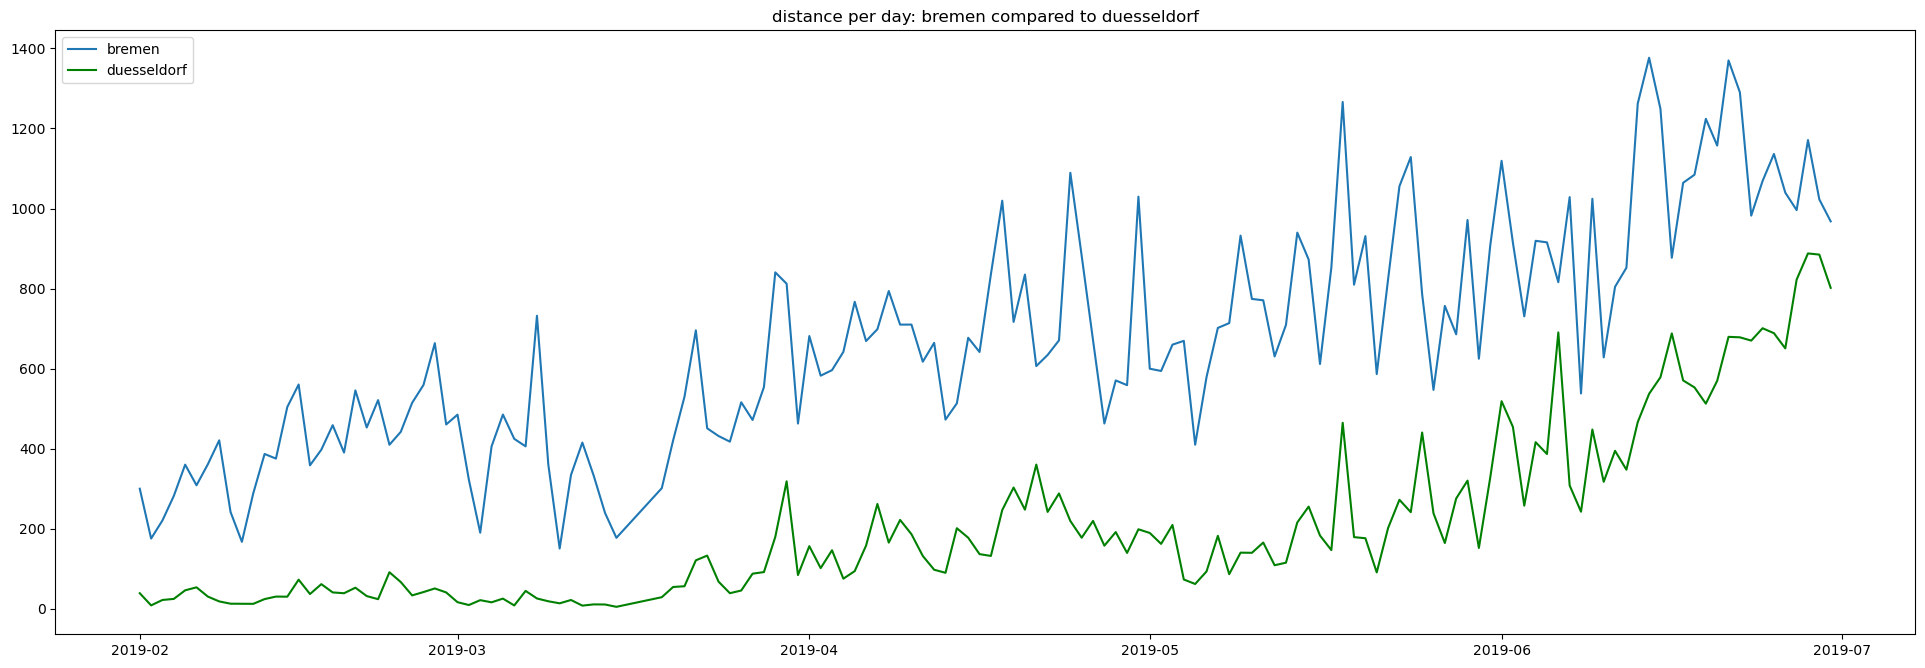

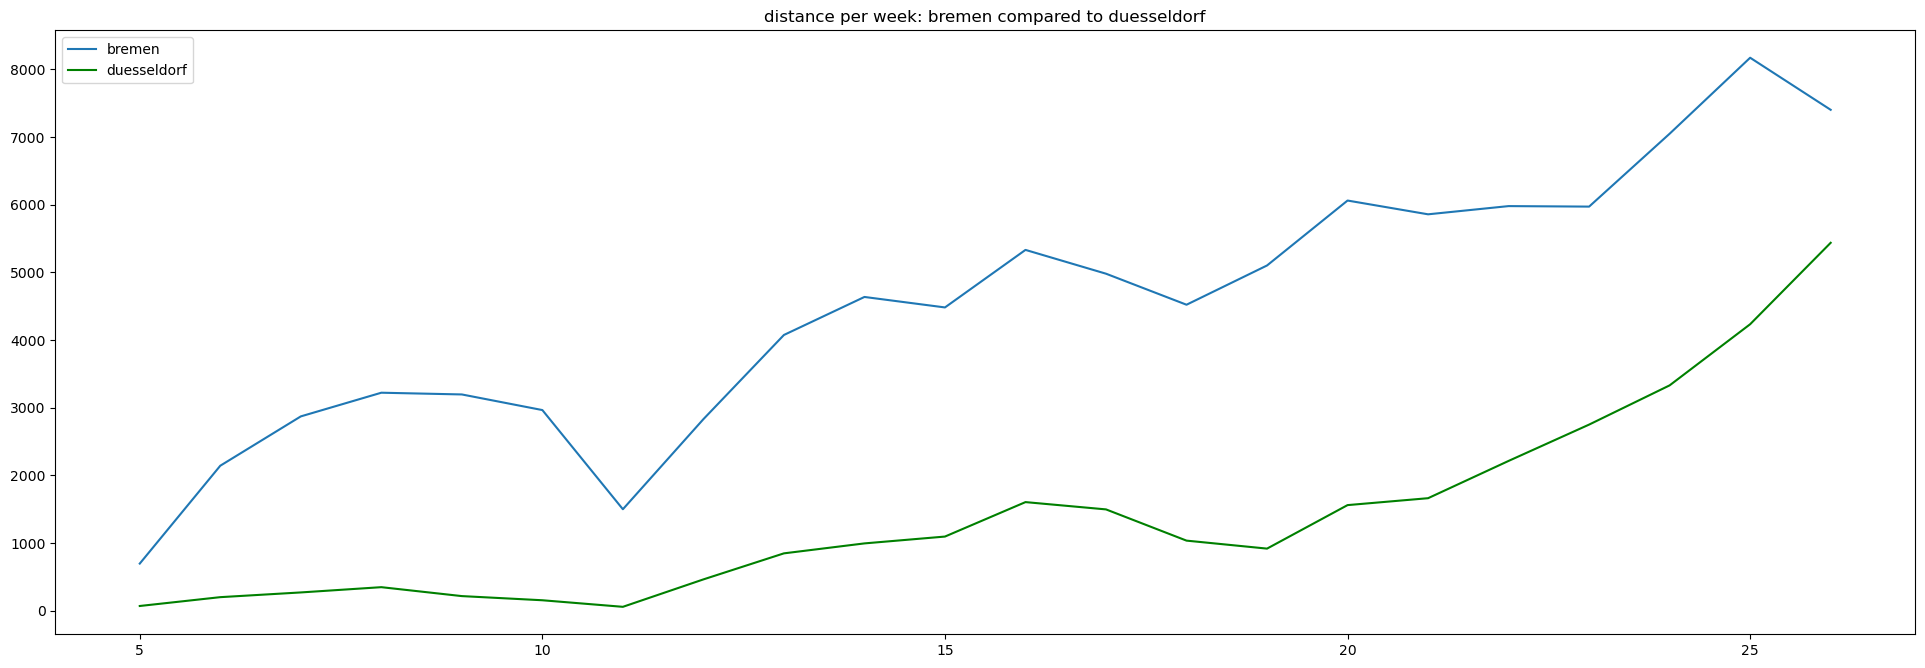

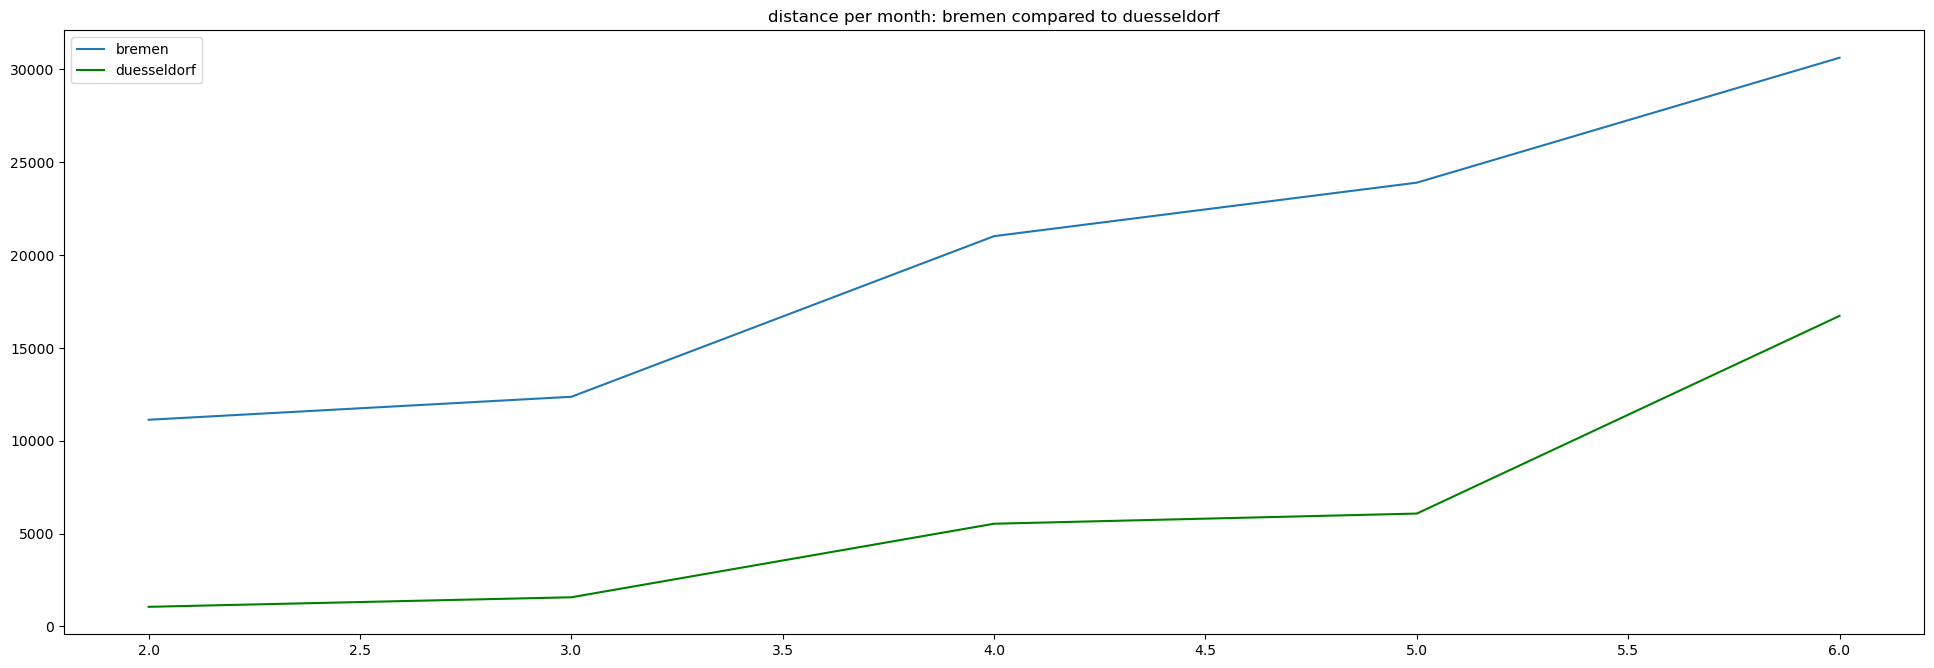

In [6]:
#time, value, title, is_weighted, is_temp
distance_graph("day", "distance", "distance per day:", False, False)
distance_graph("week", "distance", "distance per week:", False, False)
distance_graph("month", "distance", "distance per month:", False, False)

### Distance-barplot 
In the bar plot, the absolute distance per month, per weekday and per hour are discussed below. The total distance increases strongly, as can be seen in the previous view. The distance travelled per weekday is not subject to fluctuations, especially in duesseldorf. It is noticeable that the area in the morning and afternoon represent a peak. 

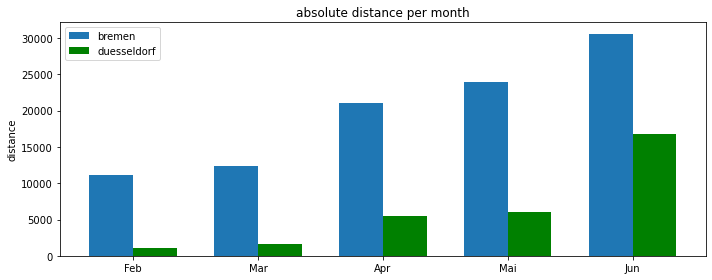

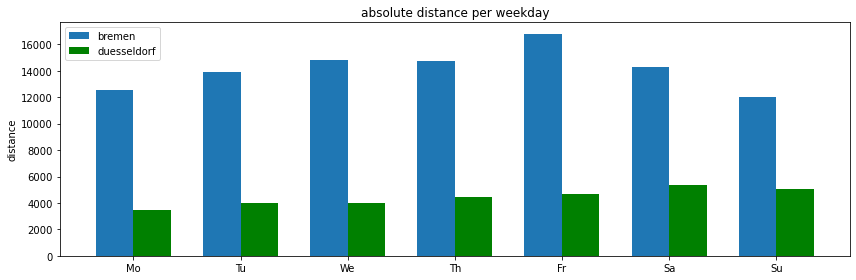

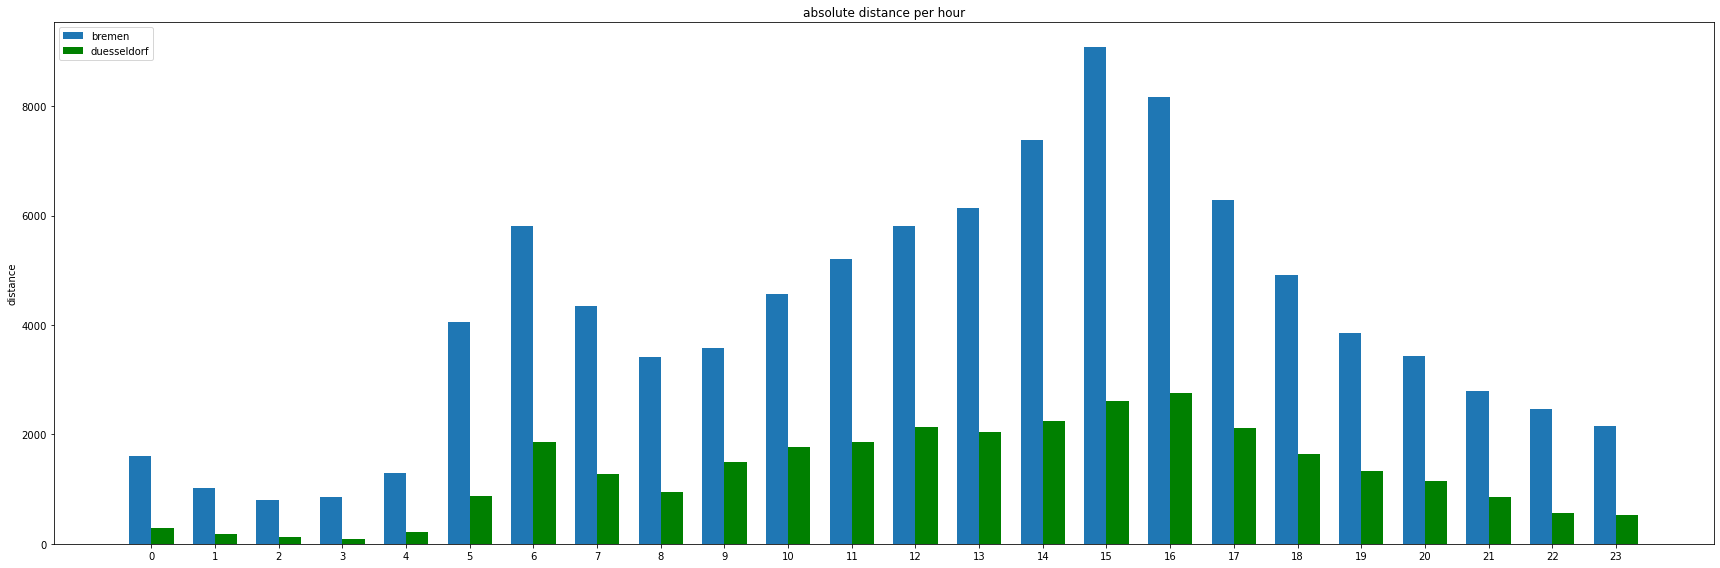

In [7]:
distance_bar('month', False)
distance_bar('weekday', False)
distance_bar('hour', False)

# Weighted trip distance
The weighted values describe the average length of a trip per time period. The following plots weight the summed distance over all trips by the number of all trips for a given period of time. 
### Distance-graph 
A clear trend, as in the previous graphs regarding an increase in the direction of summer, cannot be seen. But it looks like the respective tendencies apply to both cities. This could be the second indication of a possible weather influence. 

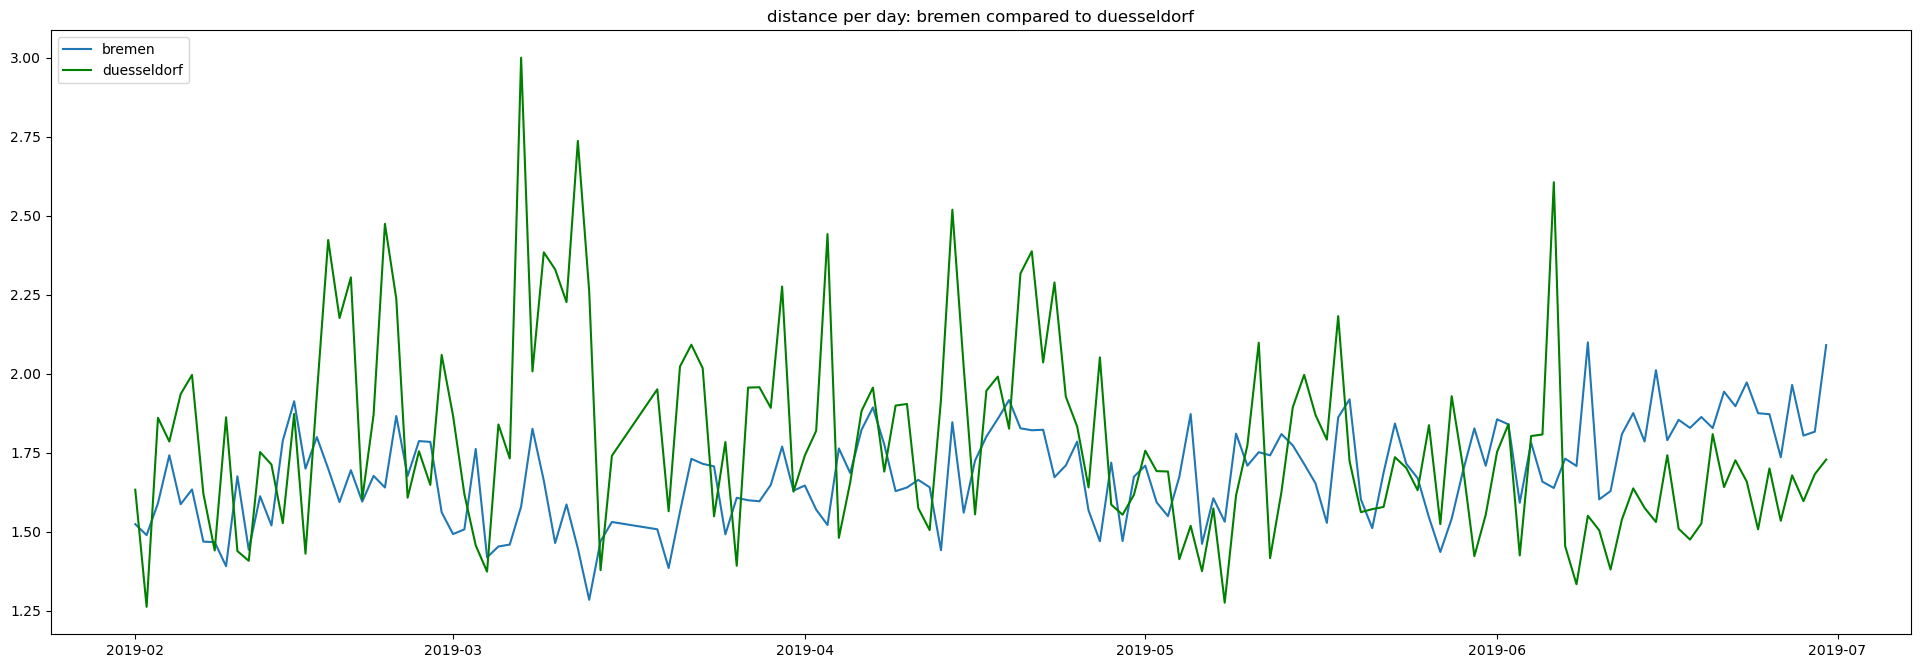

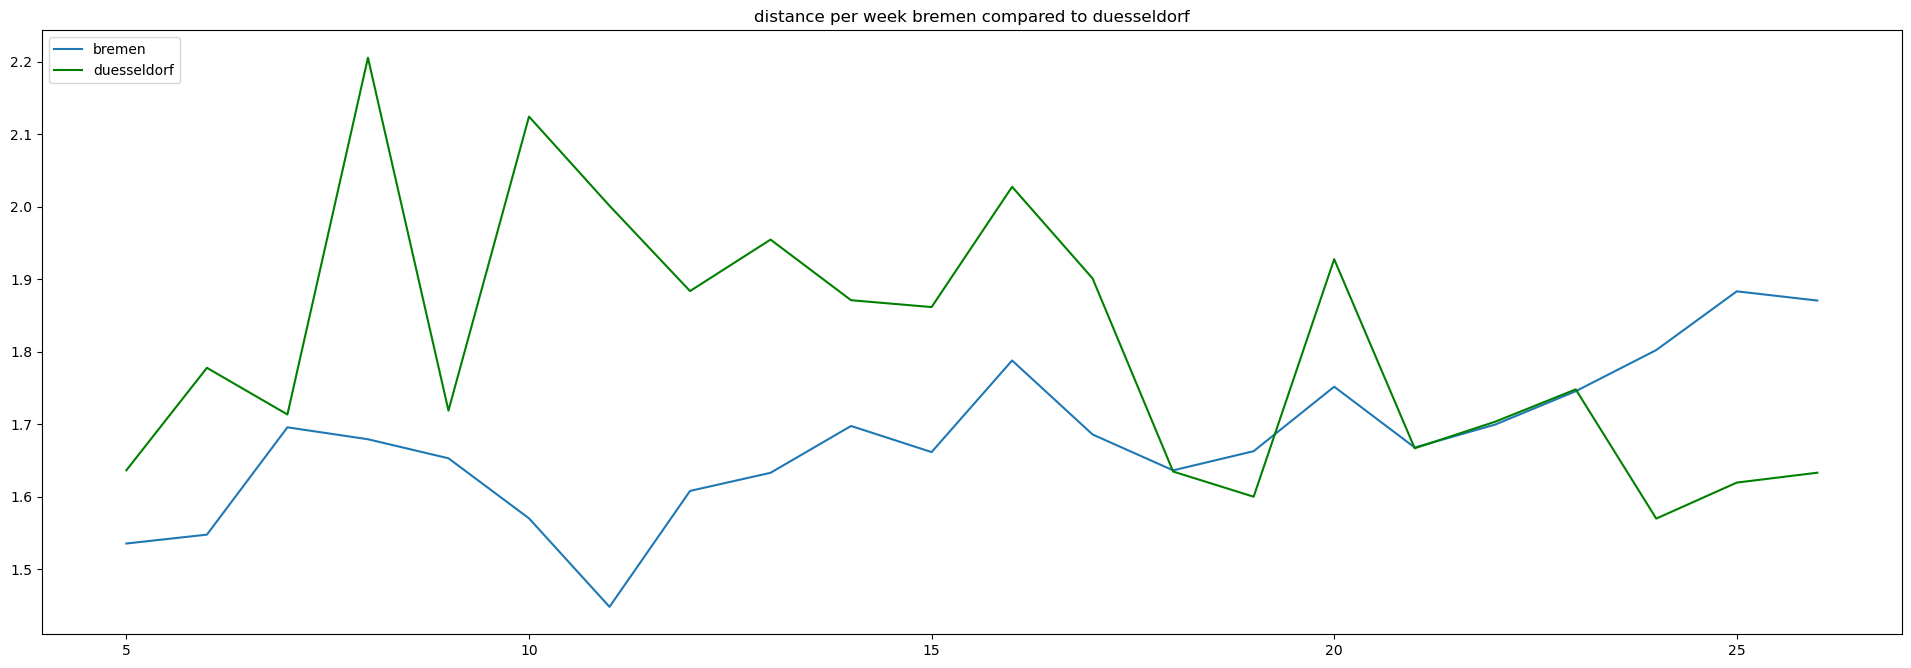

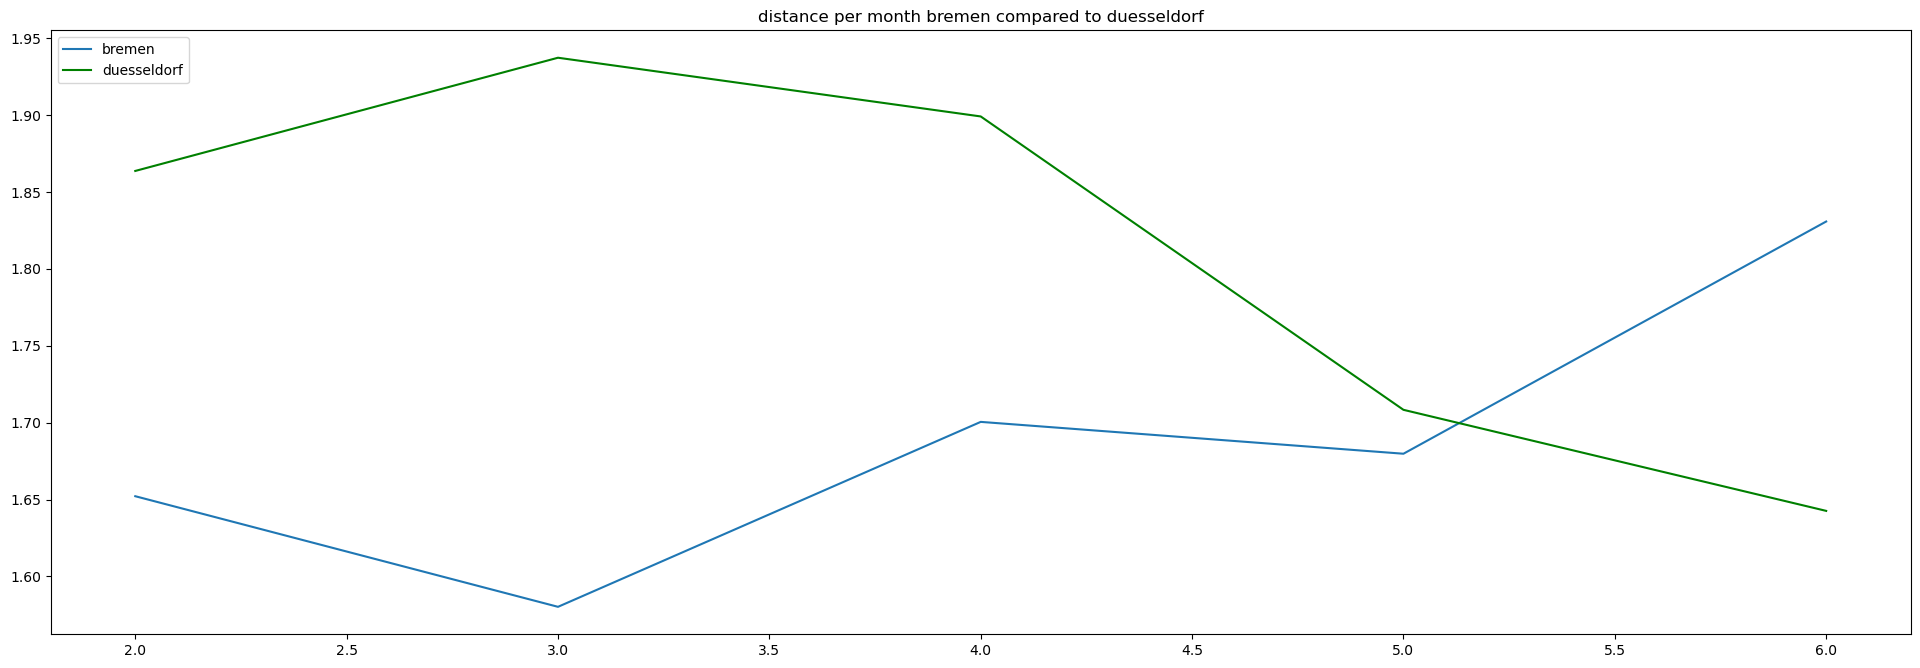

In [8]:
#time, value, title, is_weighted, is_temp
distance_graph("day", "distance", "distance per day:", True, False)
distance_graph("week", "distance", "distance per week", True, False)
distance_graph("month", "distance", "distance per month", True, False)

### Distance-barplot 
The bar chart shows once again that there is no significant difference between the months. The same applies to the individual days of the week. The time-related distance does not seem to show any significant peaks. These relationships apply to both cities in the individual observation as well as in the comparison of these.

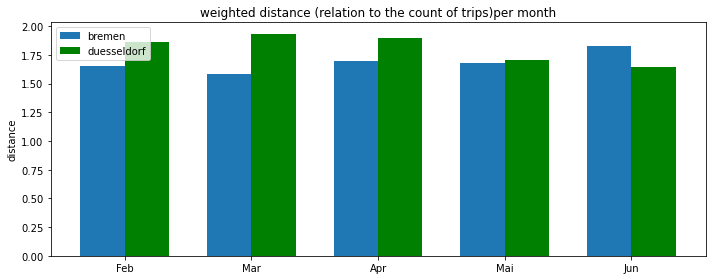

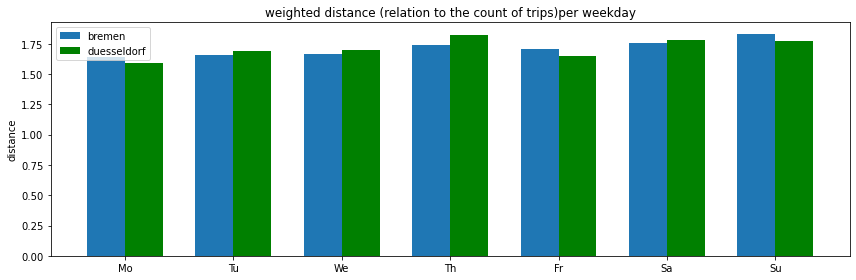

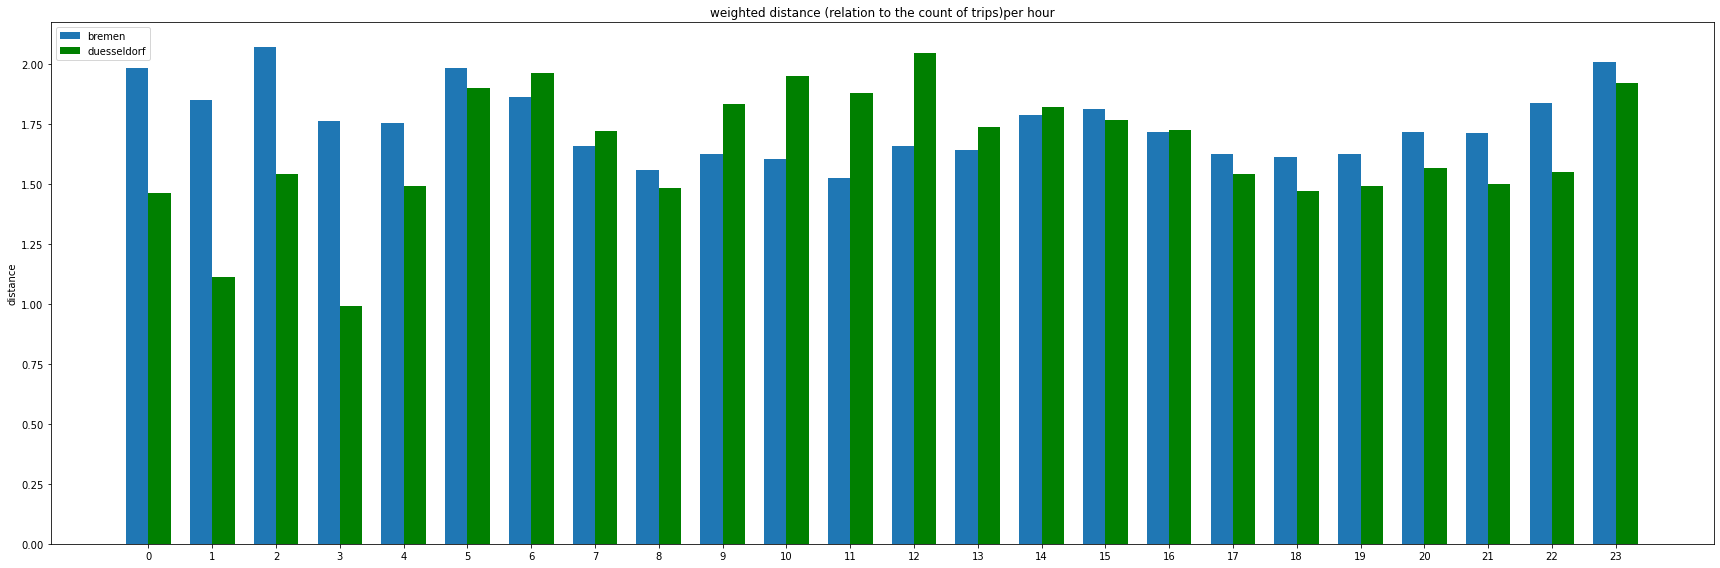

In [9]:
distance_bar('month', True)
distance_bar('weekday', True)
distance_bar('hour', True)

## Temperature with trip distance
In the following, a possible relationship between temperature and absolute and weighted distance is investigated.
### Absolute distance
The values of the absolute distance follow the course of the temperature curve, a possible direct relationship becomes apparent. The increase in temperature correlates with an increase in absolute distance and the decrease also correlates.

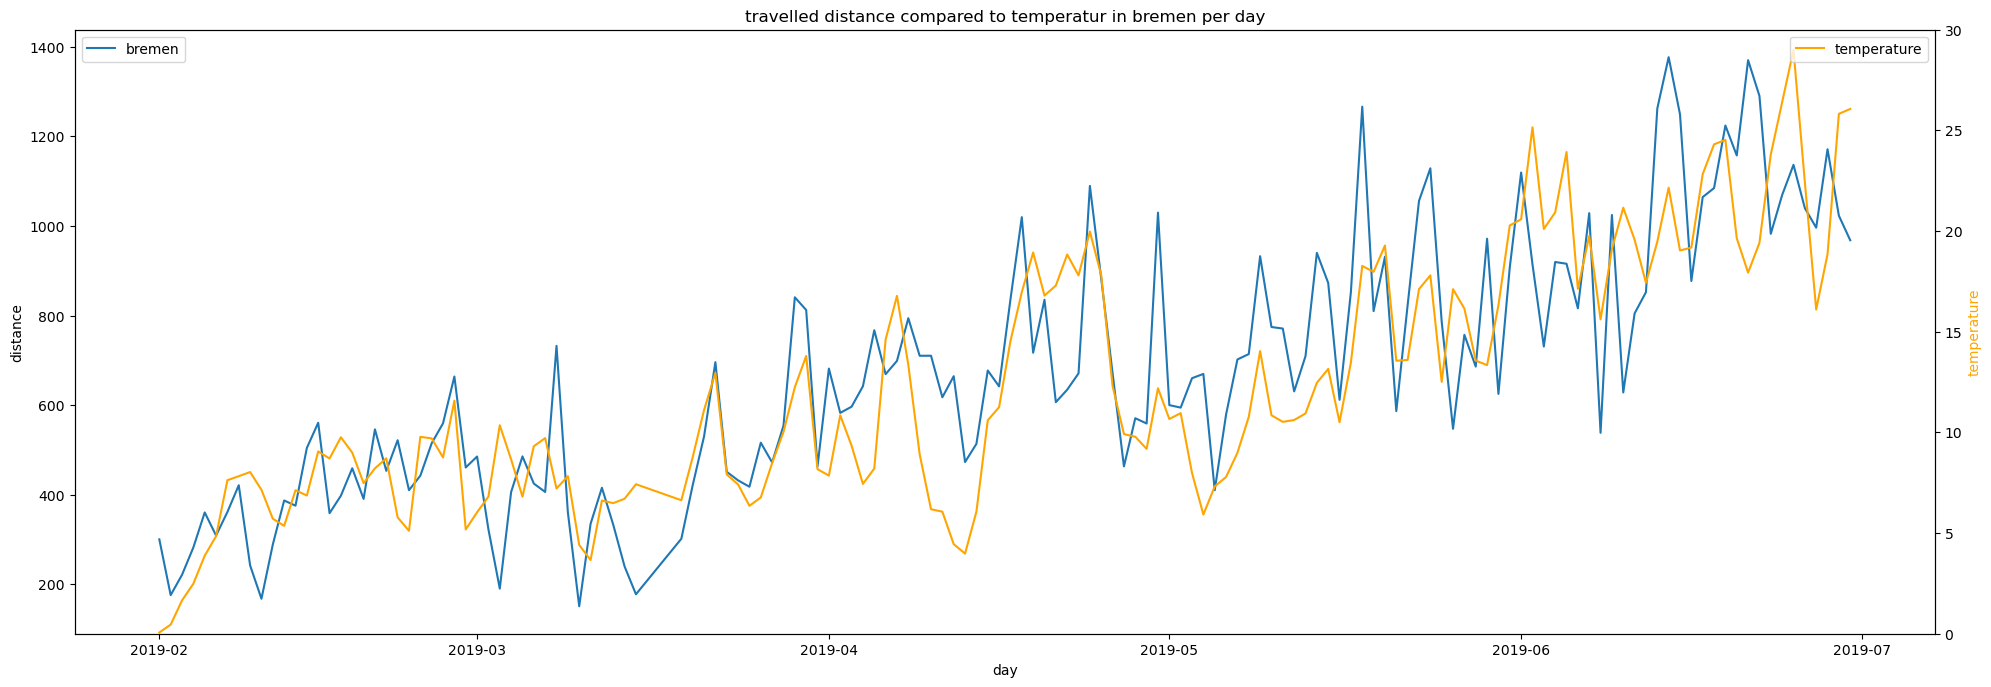

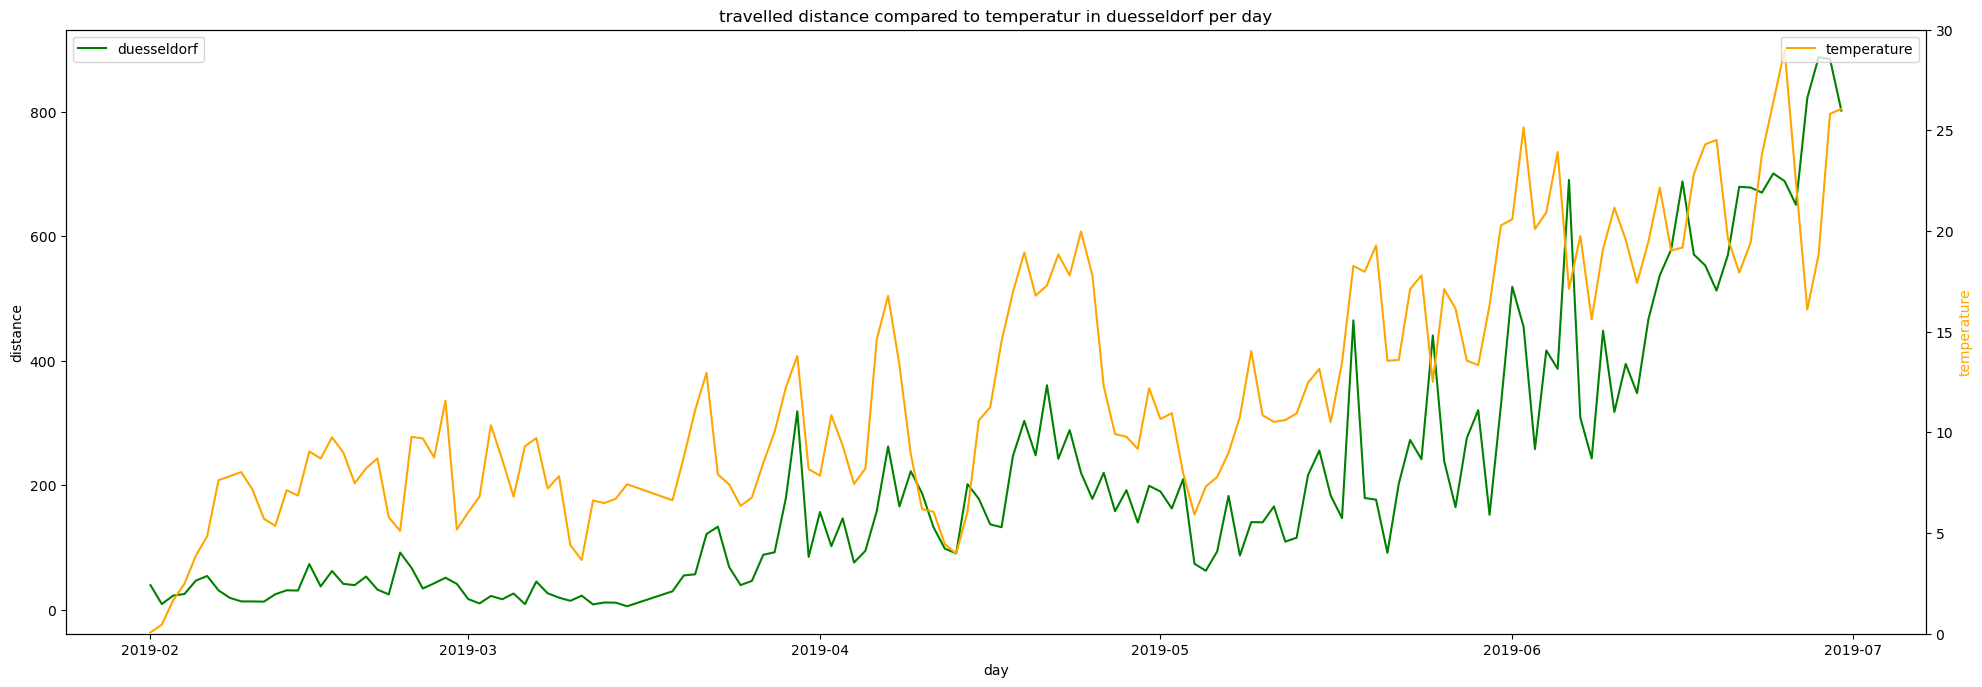

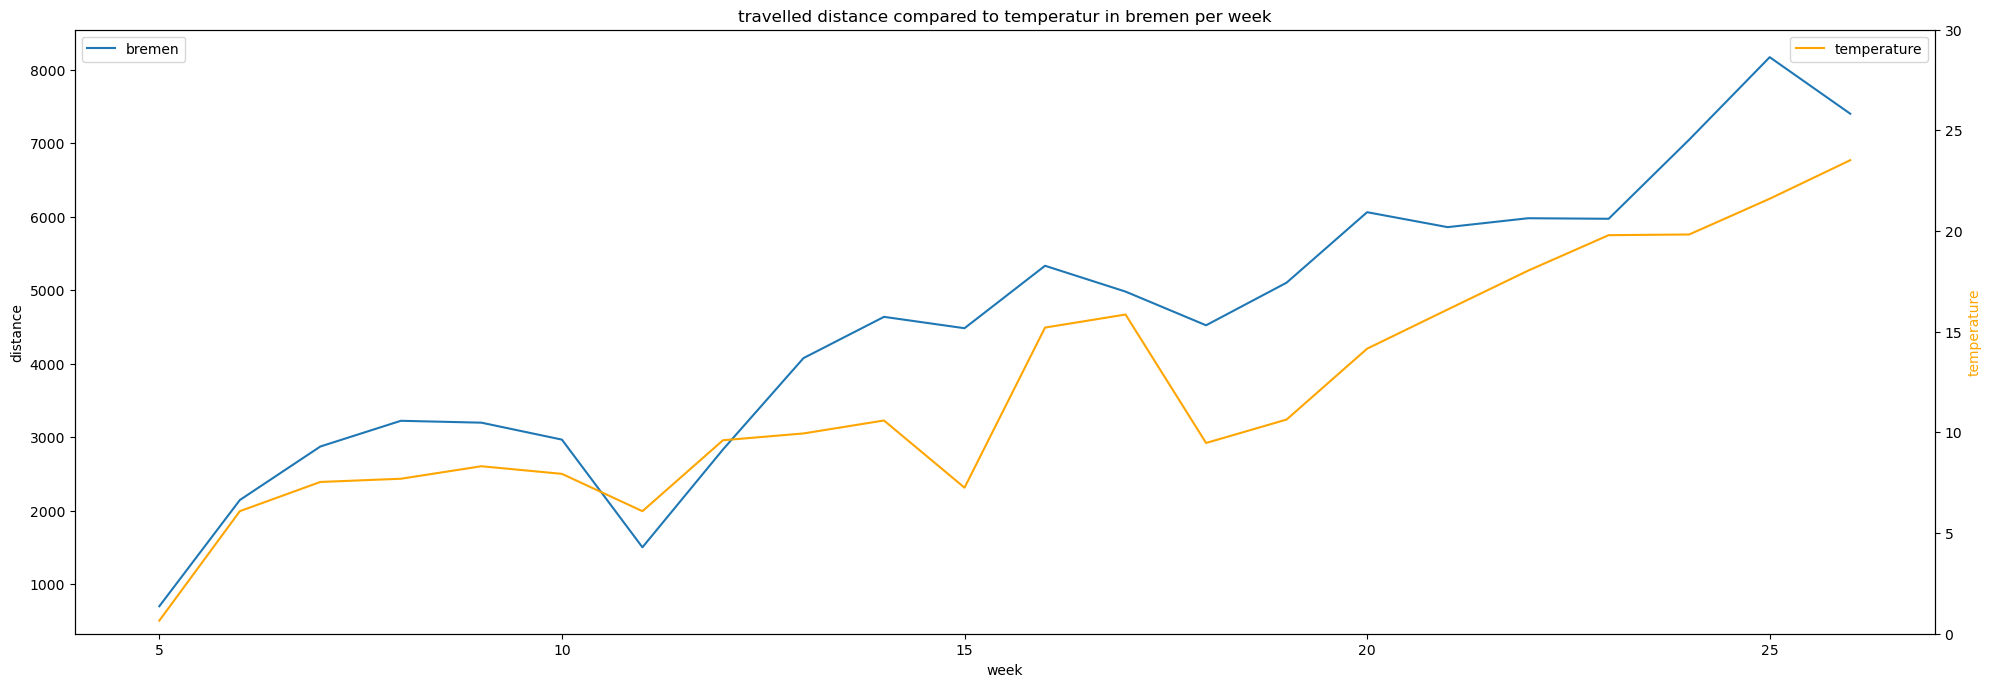

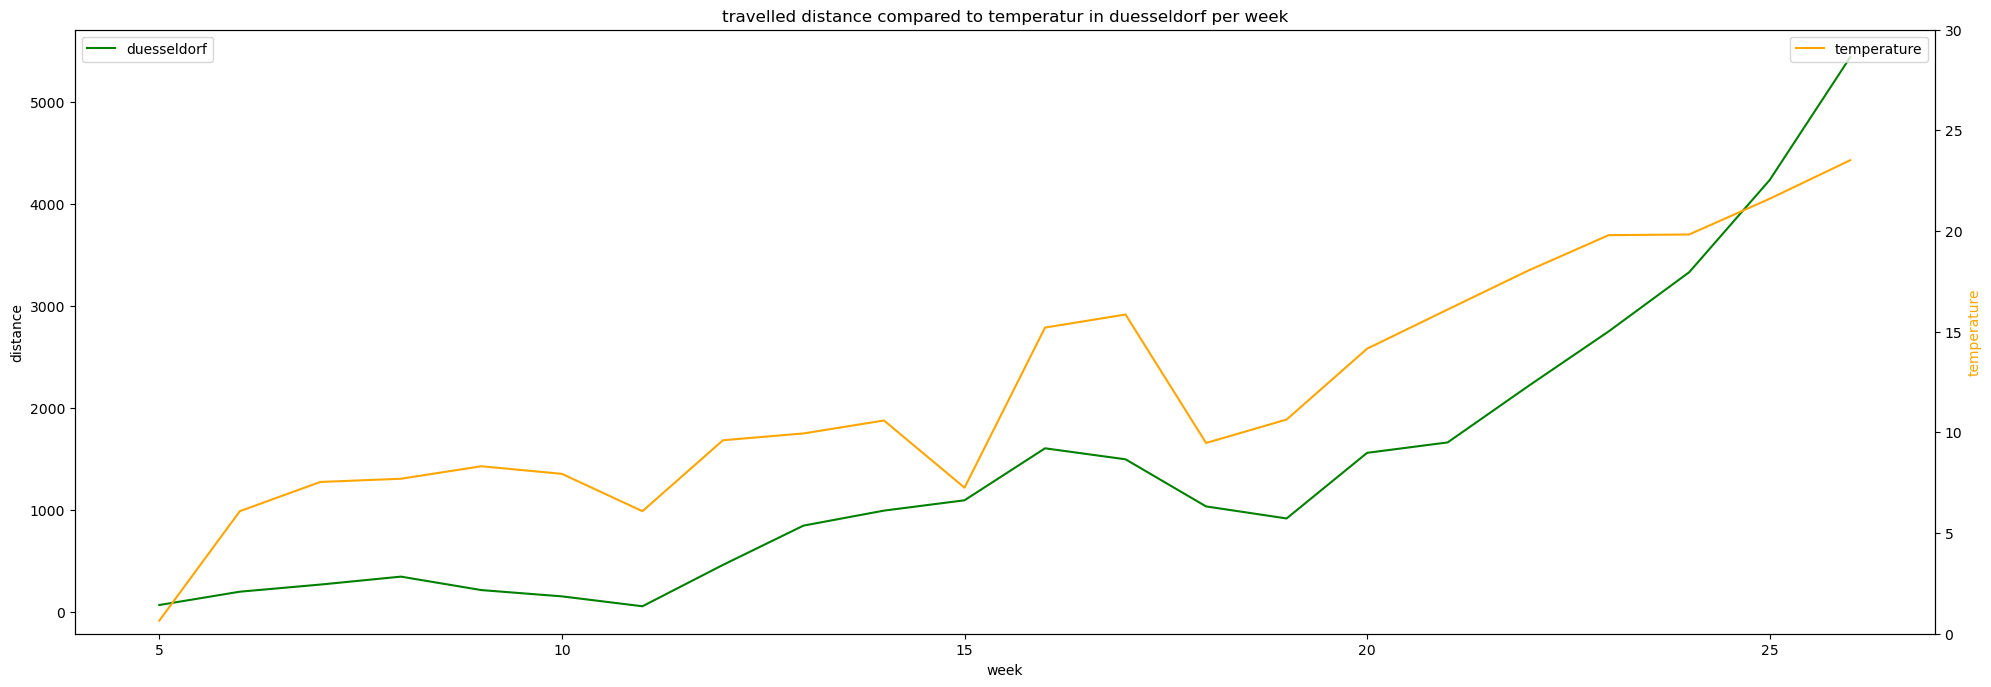

In [10]:
#time, value, title, is_weighted, is_temp
distance_graph("day", "distance", "distance per day:", False, True)
distance_graph("week", "distance", "distance per week:", False, True)

### Weighted distance
The weighted values describe the average length of a trip per period, which behaves similarly to the temperature curve for the city of Bremen when viewed week by week and day per day. This correlation cannot be observed for the city of Düsseldorf. There, an increase in temperature towards summer does not lead to an increase in the distance travelled per trip.

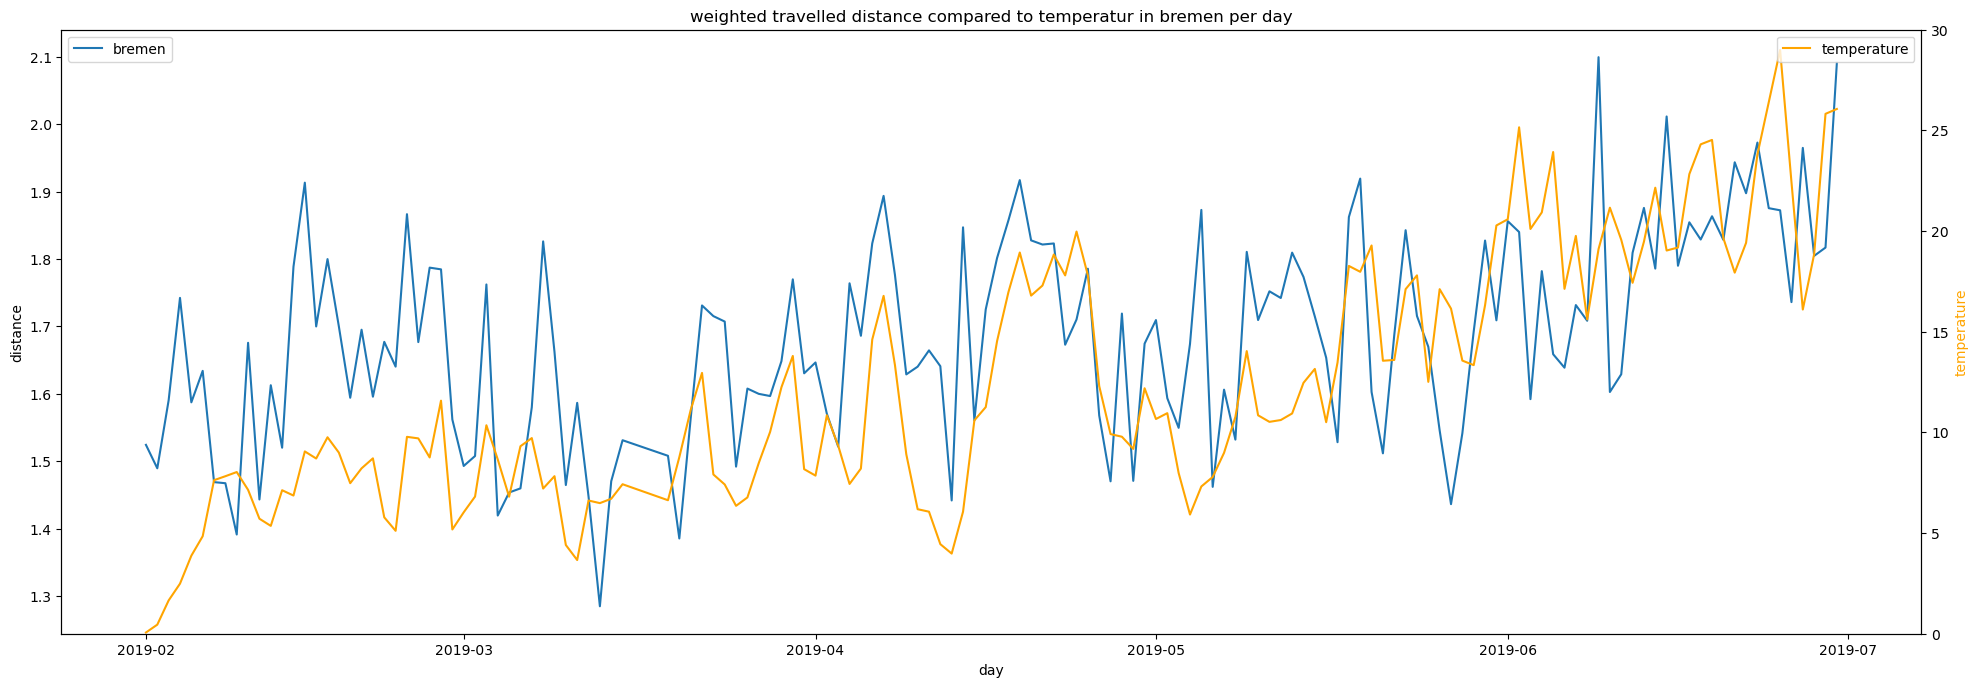

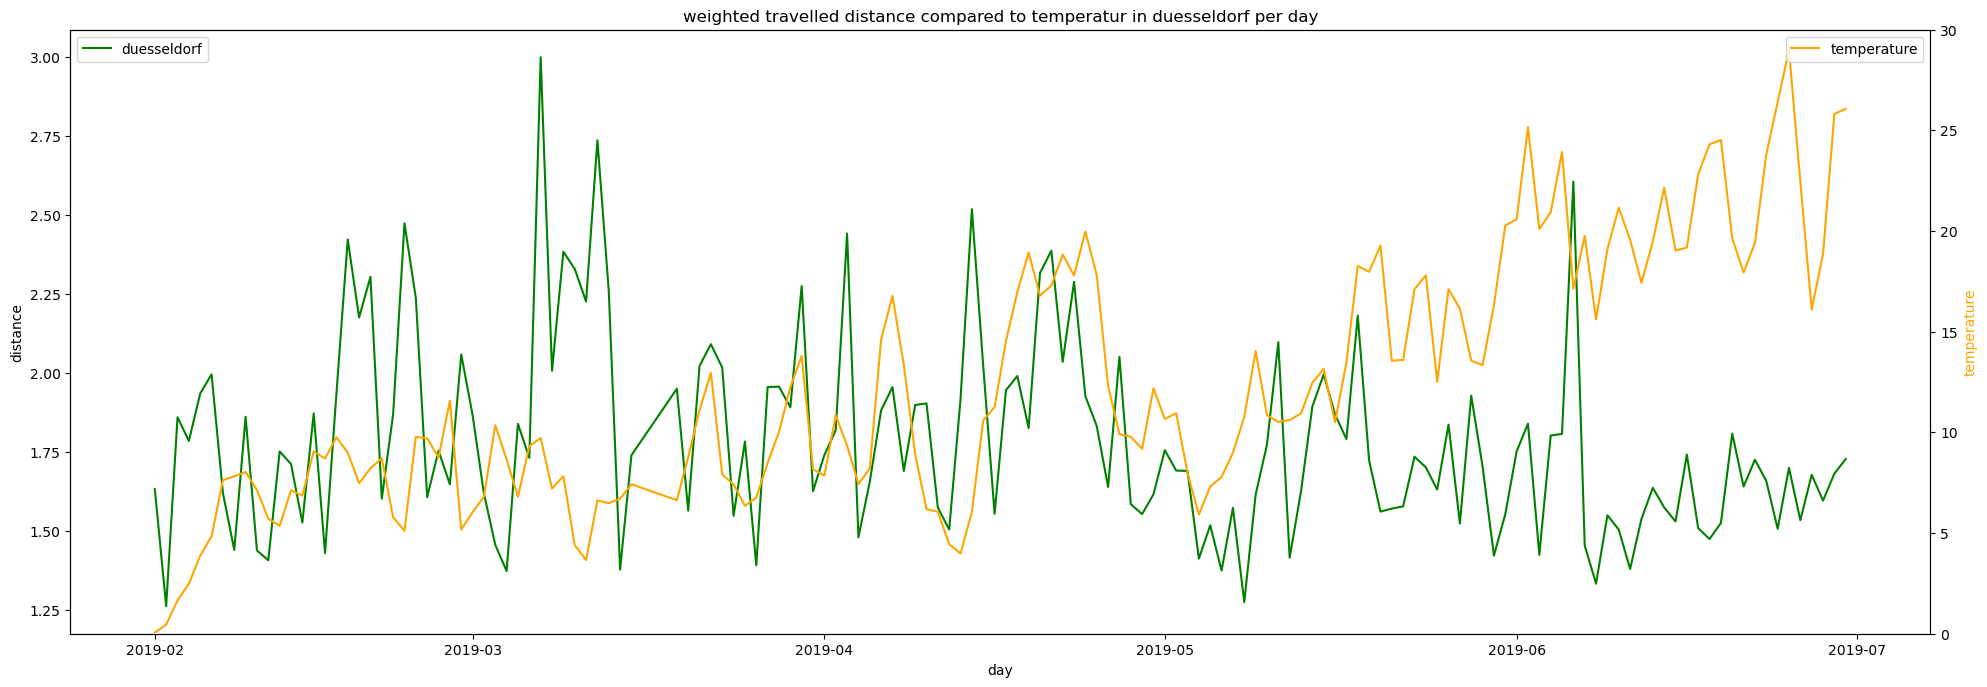

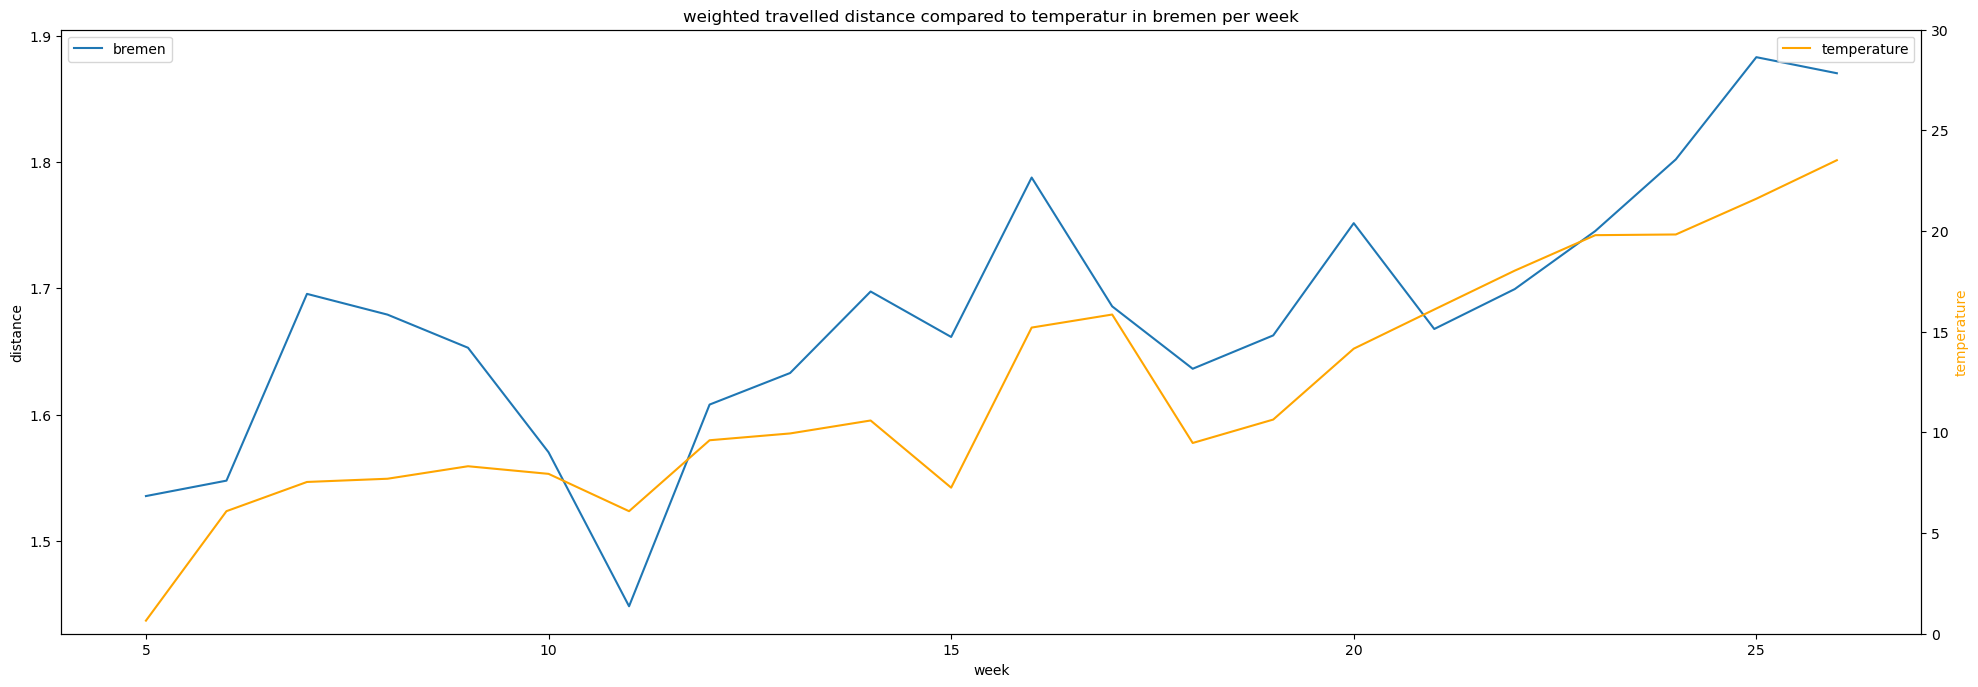

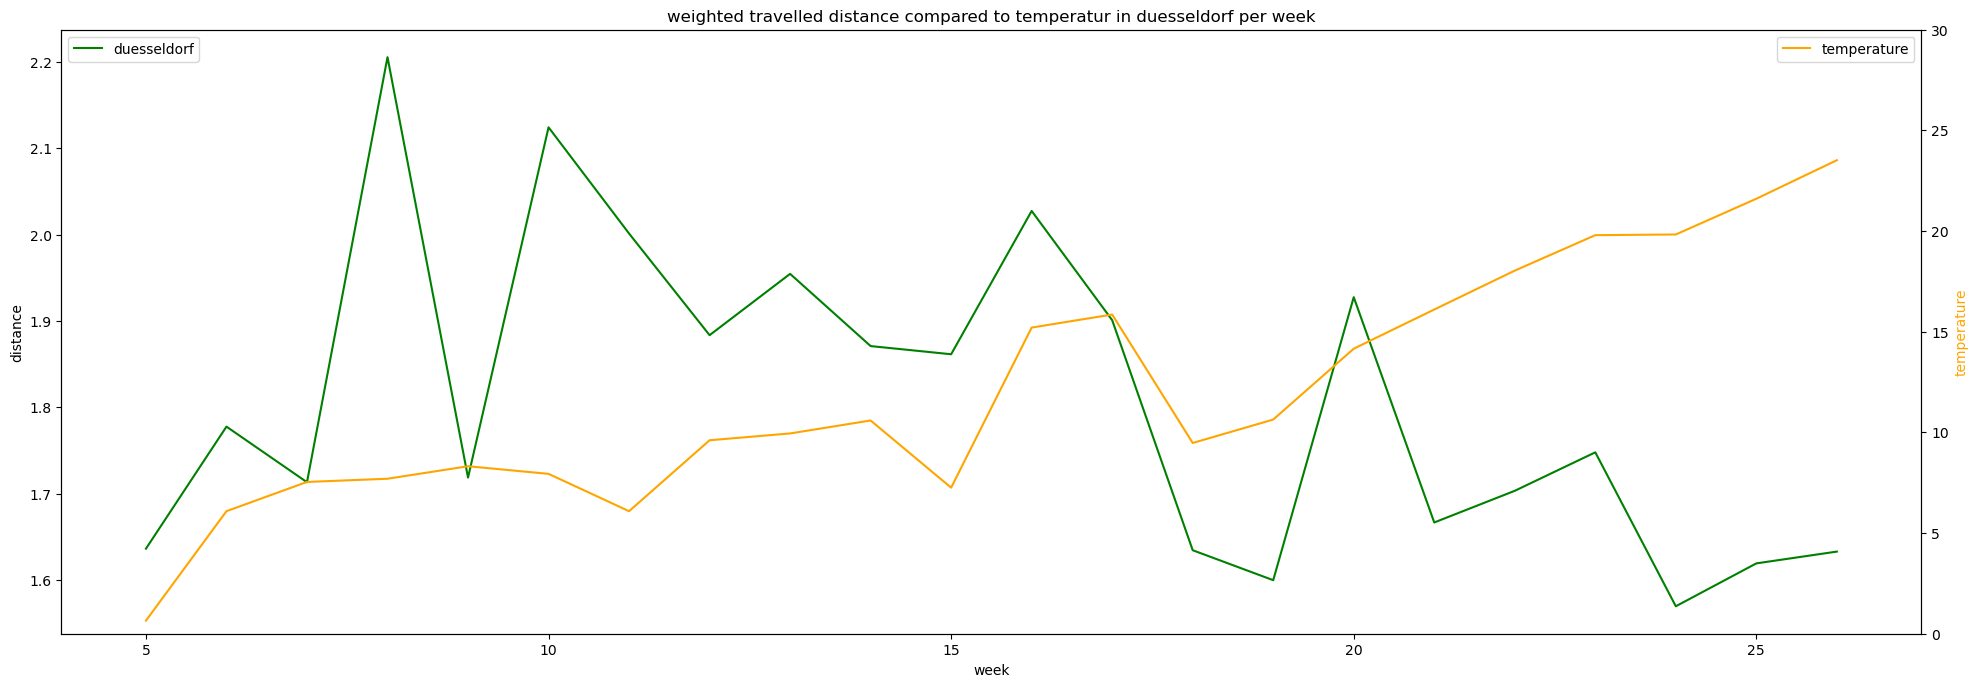

In [11]:
#time, value, title, is_weighted, is_temp
distance_graph("day", "distance", "distance per day:", True, True)
distance_graph("week", "distance", "distance per week:", True, True)

# KPI Time until next rental
## KPI description
The KPI "time until next rental" calculates for each individual bike number (b_number), how long it takes until the bike is rented out again. After the inital analysis, we decided to exclude a datapoint if the specific bike hasn't been rented out for more than 7 days because we deemed that it is unrealistic that a bike isn't being rented out for that long and assumed that the bike must have either been defect or Nextbike must have removed it from the streets, making it unavailable for rental in both cases.

#### This KPI provides to main indications:
* Based on the average time until next rental, in a specific timeframe or based on the weather, Nextbike can see if a bike hasn't been rented for longer than on average expected, which could indicate that the bike is defect or poorly placed in the city.
* Nextbike can detect general usage patterns of bikes based on the timeframe, weather or location and thereby adapt their bike fleet accordingly and in advance.
* Nextbike can also estimate the turnover rate by comparing the total number of rentals in a certain timeframe to the number of bikes that haven't been rented out in the same timeframe

### KPI calculation def


In [12]:
# TASK: calculate, for each bike, how long it takes until a specific bike is rented out again. 
#       Starting point is the moment in which the rental of the bike has ended for the first time.
#       Removing datarows of bikes that haven't been rented our for more than a week (168 hours)
#
def time_until_rental (trip_data):
    difference= []
    
    # running through the dataframe
    for i in range(len(trip_data)-1):
        
        # checking if the bike numbers match, if that is the case, calculate the time difference
        # between the two in hours
        if trip_data["b_number"][i]==trip_data["b_number"][i+1]:
            comp1=trip_data["datetime_start"][i+1]
            comp2=trip_data["datetime_end"][i]
            compare=comp1-comp2
            difference_in=compare.total_seconds()/3600
            
            # exclude datapoint if the bike hasn't been rented out for more than a week
            if difference_in>168:
                difference.append(np.nan)
            else:
                difference.append(difference_in)
        else: 
            difference.append(np.nan)
            
    difference.append(np.nan)
    
    # add column "difference" to dataframe
    trip_data["difference"] = difference 
    


In [13]:
# this function excludes a datarow if the bike has been rented out again within a week
#
def time_until_rental_removed (trip_data):
    
    difference= []
    
    # running through the dataframe
    for i in range(len(trip_data)-1):
        
        # checking if the bike numbers match, if that is the case, calculate the time difference
        # between the two in hours
        if trip_data["b_number"][i]==trip_data["b_number"][i+1]:
            comp1=trip_data["datetime_start"][i+1]
            comp2=trip_data["datetime_end"][i]
            compare=comp1-comp2
            difference_in=compare.total_seconds()/3600
            
            # exclude datapoint if the bikes hasn't been rented out for more than a week
            if difference_in<=168:
                difference.append(np.nan)
            else:
                difference.append(difference_in)
        else: 
            difference.append(np.nan)
            
    difference.append(np.nan)
    
    # add column "difference" to dataframe
    trip_data["difference"] = difference 
    
    

### Data reading 

In [14]:
dataD= read_data("duesseldorf")
dataD_removed= read_data("duesseldorf")

dataHB= read_data("bremen")
dataHB_removed= read_data("bremen")

In [15]:
time_until_rental(dataD)
time_until_rental(dataHB)
time_until_rental_removed(dataD_removed)
time_until_rental_removed(dataHB_removed)

## Data Plotting

### Data Plotting def

In [16]:
def plot_time_until_rental (trip_data, city):
    
    # removing all rows that have NaN in column "difference"
    temp=trip_data.dropna(axis=0, subset=["difference"])
    
    # create figure and axes
    fig1, (ax1) = plt.subplots(1, 1, figsize=(15,5))
    fig2, (ax2, ax3) = plt.subplots(1, 2, figsize=(15,5))
    
    # generate plots
    sns.barplot(x=temp["datetime_end"].dt.hour, y="difference", data=temp, palette="rocket", ax=ax1, ci=None)
    sns.barplot(x=temp["datetime_end"].dt.weekday, y="difference", data=temp, palette="rocket", ax=ax2, ci=None)
    sns.barplot(x=temp["datetime_end"].dt.month, y="difference", data=temp, palette="rocket", ax=ax3, ci=None) 
    
    # add labels
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=40, ha="right")
    ax1.axhline(y = trip_data['difference'].mean(), color='red', linewidth=2, alpha=.7)
    ax1.set(xlabel='Hours', ylabel="Average time until next rental (in h)")
    ax1.set_title(city+": Average time until next rental per hour")

    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=40, ha="right")
    ax2.axhline(y = trip_data['difference'].mean(), color='red', linewidth=2, alpha=.7)
    ax2.set(xlabel='Weekdays', ylabel="Average time until next rental (in h)")
    ax2.set_title(city+": Average time until next rental per weekday")

    ax3.set_xticklabels(ax3.get_xticklabels(), rotation=40, ha="right")
    ax3.axhline(y = trip_data['difference'].mean(), color='red', linewidth=2, alpha=.7)
    ax3.set(xlabel='Month', ylabel="Average time until next rental (in h)")
    ax3.set_title(city+": Average time until next rental per month" ) 
    
def plot_time_until_rental_over_time (trip_data, city):
    
    # removing all rows that have NaN in column "difference"
    temp=trip_data.dropna(axis=0, subset=["difference"])
    # create figure and axes
    fig, (ax) = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))
    
    # generate plot
    sns.lineplot(ax=ax, data=temp, x=temp["datetime_end"].dt.date, y="difference", ci=None, color="blue", label=city)
   
    # add labels
    ax.set_title(city+": Average time until next rental over time" )
    ax.set_ylabel("Average time until next rental (in h)")
    ax.set_xlabel("Date")
    ax.axhline(y = temp['difference'].mean(), color="red", linewidth=2, alpha=.7)
    ax.legend(loc="upper left")
   
    fig.subplots_adjust(left=0.05, right=0.98, top=0.96, bottom=0.25)
    
def plot_time_until_rental_over_time_weather (trip_data, city, weather):
    
    # removing all rows that have NaN in column "difference"
    temp=trip_data.dropna(axis=0, subset=["difference"])
    
    # create figure and axes
    fig, (ax) = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))
    
    # generate plot
    sns.lineplot(ax=ax, data=temp, x=temp["datetime_end"].dt.date, y="difference", ci=None, color="blue", label=city)
    ax1=plt.twinx(ax=ax)
    sns.lineplot(ax=ax1, data=temp, x=temp["datetime_end"].dt.date, y=weather, ci=None, color="green")
    
    # add labels
    ax.set_title(city+": Average time until next rental over time" )
    ax.set_ylabel("Average time until next rental (in h)")
    ax.set_xlabel("Date")
    ax.legend(loc="upper left")
    
    #add labels based on weather
    if weather=="rain":
        ax1.set_ylabel("Rain")
        ax1.set_ylim(0, temp["rain"].max())
        ax1.legend(["Rain"], loc="upper right")
    if weather=="temp":
        ax1.set_ylabel("Temperature")
        ax1.set_ylim(0, temp["temp"].max())
        ax1.legend(["Temperature"], loc="upper right")
    
    
    
    fig.subplots_adjust(left=0.05, right=0.98, top=0.96, bottom=0.25)
    


In [17]:
# Counts how many bikes haven't been rented out for more than 7 days, based on the hour/weekday/month their previous
# rental has ended at
#
def plot_time_until_rental_removed (trip_data, city):
    
    # removing all rows that have NaN in column "difference"
    temp=trip_data.dropna(axis=0, subset=["difference"])
    
    # create figure and axes
    fig1, (ax1) = plt.subplots(1, 1, figsize=(15,5))
    fig2, (ax2, ax3) = plt.subplots(1, 2, figsize=(15,5))
    
    # generate plots
    sns.countplot(x=temp["datetime_end"].dt.hour, data=temp, palette="rocket", ax=ax1)
    sns.countplot(x=temp["datetime_end"].dt.weekday, data=temp, palette="rocket", ax=ax2)
    sns.countplot(x=temp["datetime_end"].dt.month, data=temp, palette="rocket", ax=ax3) 
    
    # add labels
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=40, ha="right")
    ax1.set(xlabel="Hours", ylabel="Amount of bikes")
    ax1.set_title(city+": Average amount of bikes per hour")
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=40, ha="right")
    ax2.set(xlabel="Weekdays", ylabel="Amount of bikes")
    ax2.set_title(city+": Average amount of bikes per weekday")
    ax3.set_xticklabels(ax3.get_xticklabels(), rotation=40, ha="right")
    ax3.set(xlabel="Month", ylabel="Amount of bikes")
    ax3.set_title(city+": Average amount of bikes per month" ) 

In [18]:
# calculating the percentage of bikes that haven't been rented out for more than 7 days, based on the
# hour/weekday/month their previous rental has ended at, compared to the total number of rentals that have ended at a
# certain hour/weekday/month
#
def removed_avg_values (trip_data, trip_data_removed, time):
    # removing all rows that have NaN in column "difference"
    temp_removed=trip_data_removed.dropna(axis=0, subset=["difference"], inplace=False) 
    
    if (time=="hour"):
        time_temp_data=trip_data["datetime_end"].dt.hour
        time_temp_removed=temp_removed["datetime_end"].dt.hour
        time_avg_data=trip_data.groupby(time_temp_data)["hour"].count()  
        time_avg_removed=temp_removed.groupby(time_temp_removed)["hour"].count()
        avg = []
        for i in range(len(trip_data_removed)):
            x=trip_data_removed["datetime_end"].dt.hour[i]
            avg.append(time_avg_removed[x]/time_avg_data[x])
            
    if (time=="weekday"):
        time_temp_data=trip_data["datetime_end"].dt.weekday
        time_temp_removed=temp_removed["datetime_end"].dt.weekday
        time_avg_data=trip_data.groupby(time_temp_data)["weekday"].count()  
        time_avg_removed=temp_removed.groupby(time_temp_removed)["weekday"].count()
        avg = []
        for i in range(len(trip_data_removed)):
            x=trip_data_removed["datetime_end"].dt.weekday[i]
            avg.append(time_avg_removed[x]/time_avg_data[x])
    if (time=="month"):
        time_temp_data=trip_data["datetime_end"].dt.month
        time_temp_removed=temp_removed["datetime_end"].dt.month
        time_avg_data=trip_data.groupby(time_temp_data)["month"].count()  
        time_avg_removed=temp_removed.groupby(time_temp_removed)["month"].count()
        avg = []
        for i in range(len(trip_data_removed)):
            x=trip_data_removed["datetime_end"].dt.month[i]
            
            # adding an if-clause cause there no bike rentals that begin in july (7th month)
            if (x not in range(len(time_avg_removed)+2)):
                avg.append(0)
            else: avg.append(time_avg_removed[x]/time_avg_data[x])
    
    return avg

# Plotting the percentage of bikes that haven't been rented out for more than 7 days
#
def plot_time_until_rental_removed_avg (trip_data, trip_data_removed, city):
    # adding average values     
    trip_data_removed["avg_hour"]= removed_avg_values(trip_data, trip_data_removed, "hour")
    trip_data_removed["avg_weekday"]= removed_avg_values(trip_data, trip_data_removed, "weekday")
    trip_data_removed["avg_month"]= removed_avg_values(trip_data, trip_data_removed, "month")
    
    # removing all rows that have NaN in column "difference"
    temp=trip_data_removed.dropna(axis=0, subset=["difference"], inplace=False)    
    
    # create figure and axes
    fig1, (ax1) = plt.subplots(1, 1, figsize=(15,5))
    fig2, (ax2, ax3) = plt.subplots(1, 2, figsize=(15,5))
    
    # generate plots
    sns.barplot(x=temp["datetime_end"].dt.hour, y="avg_hour", data=temp, palette="rocket", ax=ax1, ci=None)
    sns.barplot(x=temp["datetime_end"].dt.weekday, y="avg_weekday", data=temp, palette="rocket", ax=ax2, ci=None)
    sns.barplot(x=temp["datetime_end"].dt.month, y="avg_month", data=temp, palette="rocket", ax=ax3, ci=None) 
    
    # add labels
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=40, ha="right")
    ax1.axhline(y = temp['avg_hour'].mean(), color='red', linewidth=2, alpha=.7)
    ax1.set(xlabel='Hours', ylabel="Percentage of bikes not rented out")
    ax1.set_title(city+": Percentage of bikes that haven't been rented out per hour")

    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=40, ha="right")
    ax2.axhline(y = temp['avg_weekday'].mean(), color='red', linewidth=2, alpha=.7)
    ax2.set(xlabel='Weekdays', ylabel="Percentage of removed bikes")
    ax2.set_title(city+": Percentage of bikes that haven't been rented out per weekday")

    ax3.set_xticklabels(ax3.get_xticklabels(), rotation=40, ha="right")
    ax3.axhline(y = temp['avg_month'].mean(), color='red', linewidth=2, alpha=.7)
    ax3.set(xlabel='Month', ylabel="Percentage of removed bikes")
    ax3.set_title(city+": Percentage of bikes that haven't been rented out per month" ) 

### Average time until next rental grouped by hour/weekday/month

#### Duesseldorf

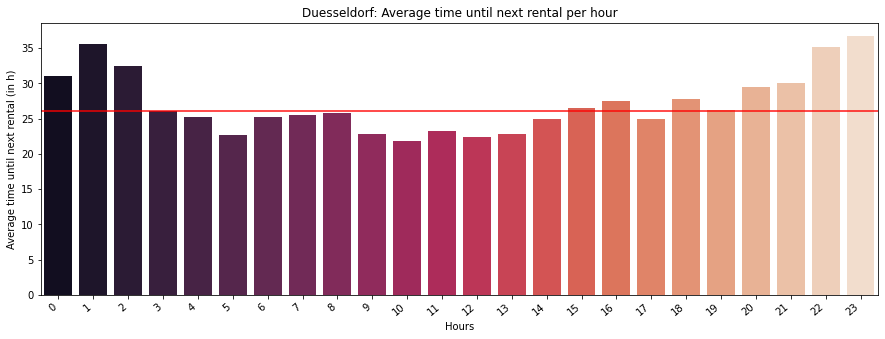

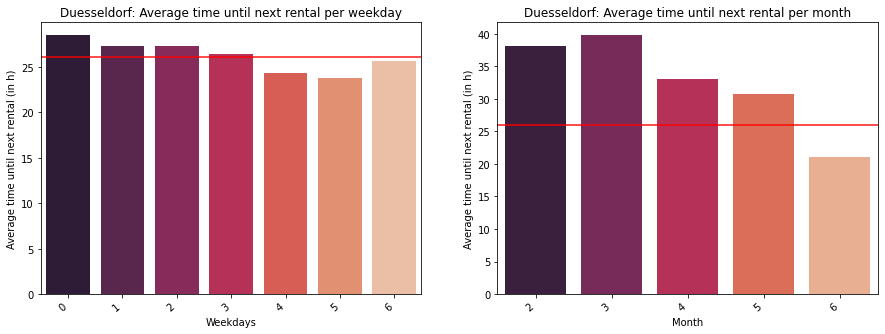

In [19]:
plot_time_until_rental (dataD, "Duesseldorf")

We can see that the time difference between two trips with the same bike is on average close to 26 hours, meaning one bike trip per day. We can also see that the time until next rental is at nighttime on average higher than during the day. 
The weekdays diagram shows that the time until next rental is above average on the first four days of the week and below average on the last three days.
The final diagram displays that the average time until next rental decreases as the months go on with the only anomaly being march.

#### Bremen

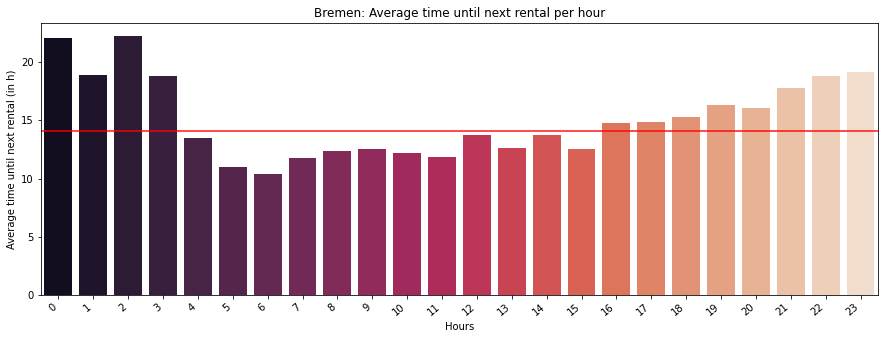

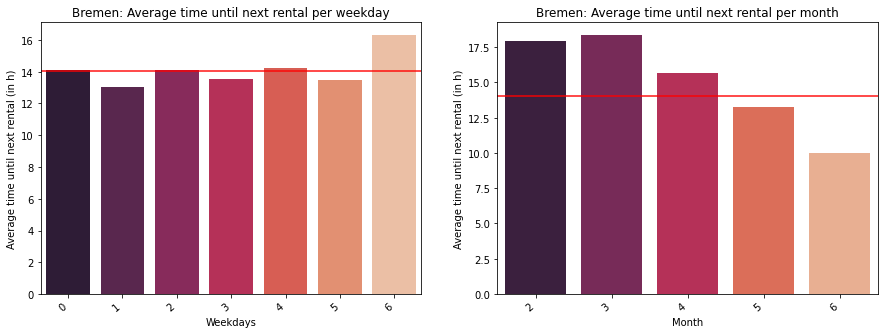

In [20]:
plot_time_until_rental (dataHB, "Bremen")

For Bremen, we can see the same trends as we already depict for Duesseldorf. The only two big differences are that, first, the time until next rental is on average lower in Bremen with an average of around 14 hours, compared to Duesseldorf with nearly 26 hours and second, the time until next rental based on weekdays is close to average on all days of the week except for sunday.

### Average time until next rental over time

#### Duesseldorf

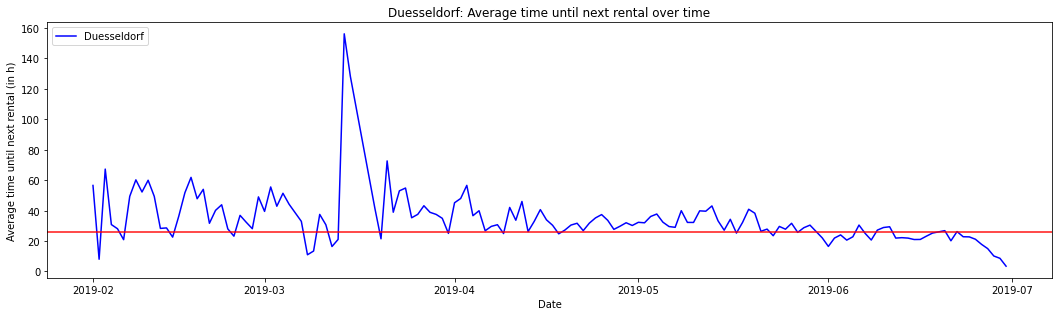

In [21]:
plot_time_until_rental_over_time(dataD, "Duesseldorf")

Noticeably, we can see that the fluctuation in average time until next rental decreases from april onwards. We can also exhibit a lack of data in mid march which causes a big peak in the diagram. 

#### Bremen

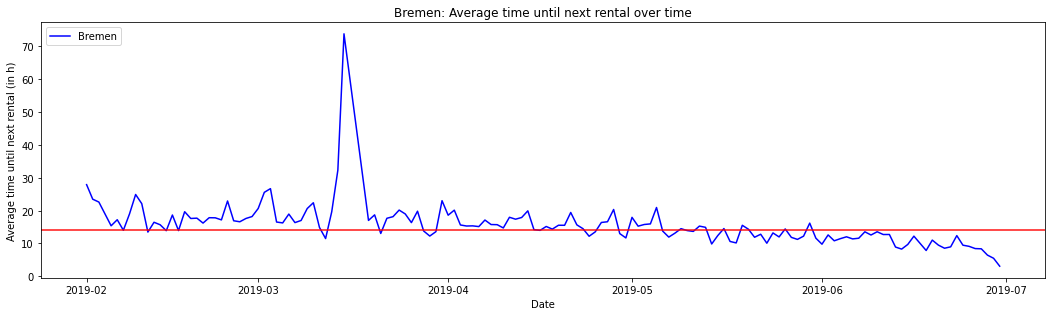

In [22]:
plot_time_until_rental_over_time(dataHB, "Bremen")

Also for Bremen we can see a decrease in fluctuation but not as noticeably as for Duesseldorf. The diagram also indicates a clear trend from above average values at the beginning of the time interval towards below average values from mid may onwards.

### Average time until next rental over time with weather

#### Comparing the average time until next rental with the temperature

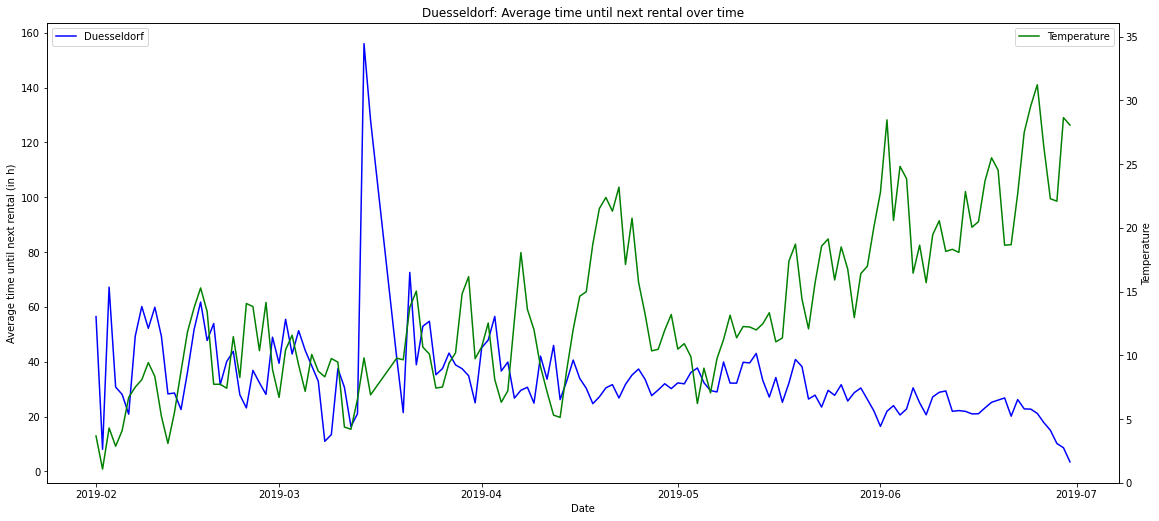

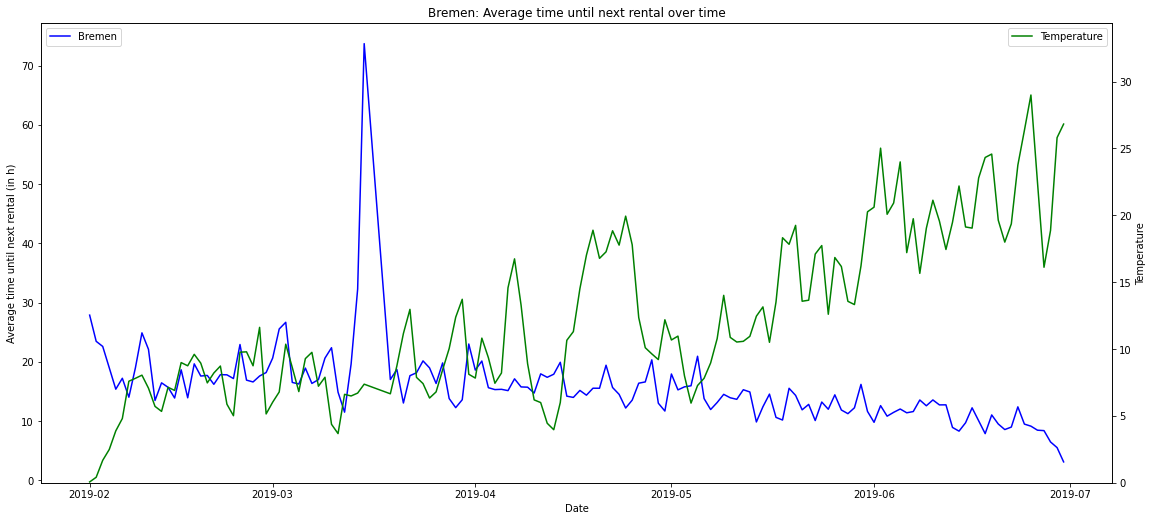

In [23]:
plot_time_until_rental_over_time_weather(dataD, "Duesseldorf", "temp")
plot_time_until_rental_over_time_weather(dataHB, "Bremen", "temp")

The diagrams highlight a clear trend between raising temperatures and a decrease in average time until next rental

#### Comparing the average time until next rental with rain

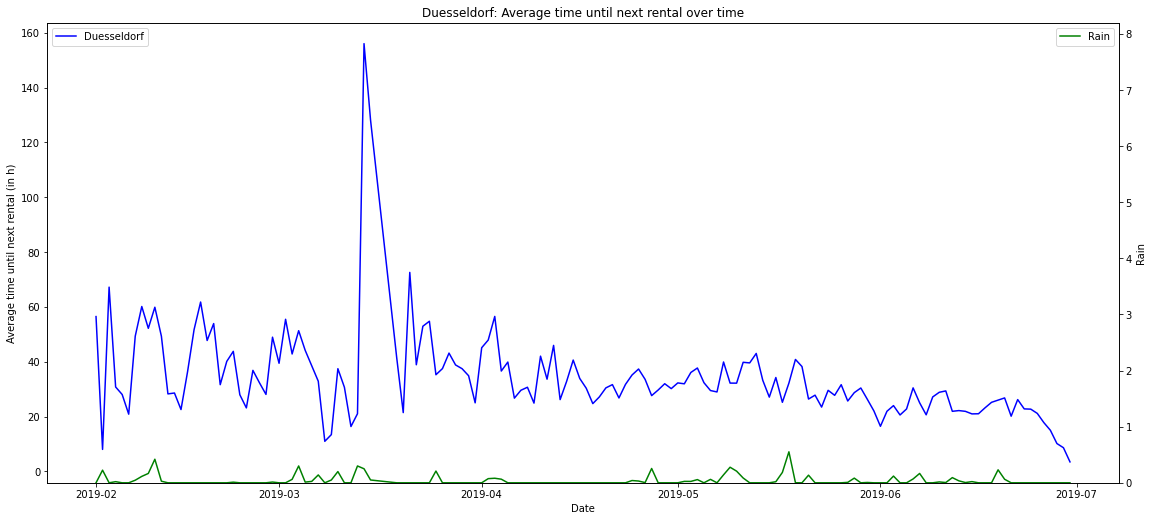

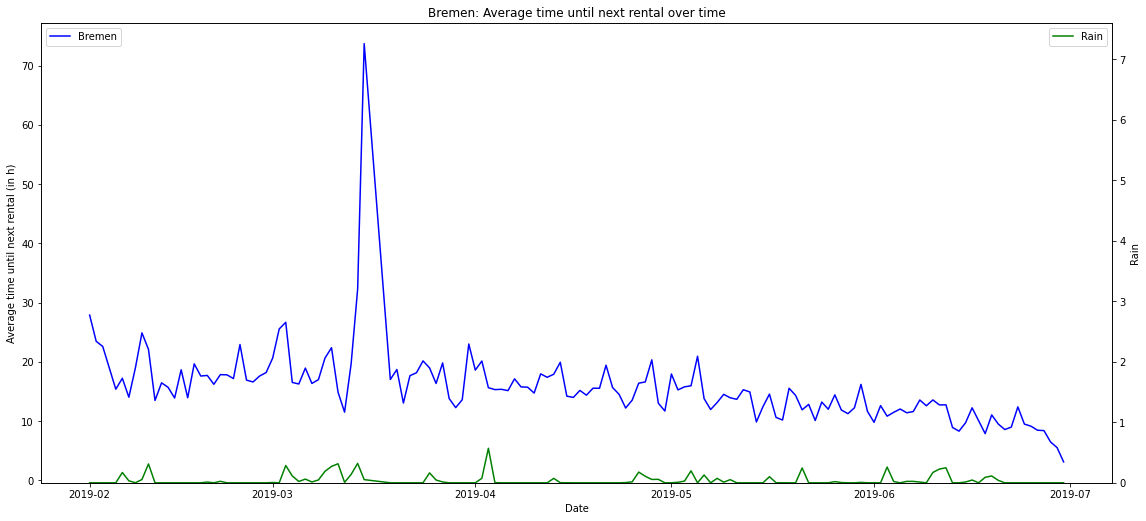

In [24]:
plot_time_until_rental_over_time_weather(dataD, "Duesseldorf", "rain")
plot_time_until_rental_over_time_weather(dataHB, "Bremen", "rain")

We can see some correlation between rain and the time until next rental as well, which could explain why the average time until next rental per month peaked in march.

### Experimenting with the removed data
#### Amount of bikes that haven't been rented out for more than 7 days

In [25]:
#plot_time_until_rental_removed (dataD_removed, "Duesseldorf")
#plot_time_until_rental_removed (dataHB_removed, "Bremen")

We wanted to find out whether there is a certain pattern in which bikes don't get rented out, in the following called "vanished". As we can see in the hourly graph, most bikes vanish during the day with peaks at 7am in the morning for both cities and 3pm in the afternoon for Duesseldorf and 4pm for Bremen. Differences between the two cities become noticealbe in the weekday and monthly graph. In Duesseldorf, bikes vanished mostly at the end of the week, from Friday to Sunday. In contrast, for Bremen, we can see a clear cut between bikes vanishing during the week and at the weekend.
For the monthly figure, we can see that in Duesseldorf many more bikes vanished from month April to June compared to Bremen where the amount of bikes vanishing peaked in March.

#### Percentage of removed datarows compared to total rentals

After looking at the total amount of bikes that haven't been rented out for 7 days, we now want to look at the percentage of bikes that haven't been rented out for more than 7 days, compared to the total number of bikes rentals that ended at the same hour/weekday/month

In [26]:
#plot_time_until_rental_removed_avg (dataD, dataD_removed, "Duesseldorf")

For Duesseldorf, we can see in the hourly graph that bikes are more likely to vanish early on in the day at around 1am to 2am. We can also see another minor peak in the morning hours at around 7/8am. The percentages are the lowest at 5am and 8pm. The weekday graph displays that the percentage of bikes vanishing per weekday is quite consistent throughout the entire week. The monthly graph however, shows downward trend of bikes vanishing as the months go on. 

In [27]:
#plot_time_until_rental_removed_avg (dataHB, dataHB_removed, "Bremen")

For Bremen, we can see similar tendencies. The hourly graph peaks at 2am, and is at it's lowest at 5am and 8pm. The weekday graph remains quite consistent throughout the week, although we can see that the percentage drops a bit at Friday and Saturday. Also in Bremen, the monthly graph decreases as the months go on but the graph now peaks in March instead of February. The difference in percentage compared to Duesseldorf is also quite significant. While Duesseldorf peaked at ca. 23% in February, Bremen peaked in March at ca. 4.1% 

If we now go back and compare the monthly graph for total amount of bikes not rented out for more than 7 days to the percentage of bikes not rented out for more than 7 days, we can see a strong similarity between the two graphs for Bremen. For Duesseldorf however, we can see that total amount of bikes was fairly low in February and March and the percentage was fairly high for both these months. This indicates a high turnover rate at the beginning of our observation intervall for Duesseldorf.

# KPI Revenue

## Styles

In [28]:
# set seaborn styles
sns.set()
sns.set_style("whitegrid")
sns.set_palette("rocket")

# set pandas display styles
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 2000)
pd.set_option('display.max_rows', 500)
%config IPCompleter.greedy=True

## KPI generation

### Description of KPI
The KPI "Revenue" reflects the amount of € generated in a specific time interval if we assume that all trips belong to the regular price segment (i.e. all trips are billed by 30-minute intervals, each started interval amounting to 1€).

**Important**: for sake of simplicity, we assume that all trips are billed by the 30-minute interval pricing. Thus, a part of the actual price structure, the monthly subscription, is disregarded.

#### Calculation:
- Count trip duration intervals for each trip and set the revenue to the number of 30-minute durations fitting into the trip duration, and add 1 to the revenue if division of trip duration by 30-minute interval has a remainder > 0. 
- Examples: 
    1. If a trip was 30 mins long: trip duration / 30-minute interval = 30 / 30 = 1 --> revenue = 1 
    2. If a trip was 1 hour 12 mins long: trip duration / 30-minute interval = 72/30 = 2, remainder: 12 > 0 --> revenue = 2+1 = 3

#### Value creation for the company by the KPI
The KPI could indicate the degree to which the bike rental with the assumed price structure and current operating strategy is economically viable, for each city.
- With the help of hourly revenue, one could point out less economically viable time windows, e.g. night hours or days with extreme weather, when comparing the revenue with and relate it to one of the aforementioned aspects. If the hourly revenue is surprisingly low when it is raining, the company could adapt its strategy and reduce the fleet size for the next day when the weather forecast is strongly predicting rain for the next day, to reduce costs.
- Also, one might try to justify lowering the fleet size in locations of the city, where the generated revenue is comparably low.
- The revenue can also be used for planning purposes, since the revenue is a key aspect of financial planning.

##### Main Processing function that generates the KPI

In [29]:
def generate_revenue_per_hour_for_city(data, city, start_date, end_date):
    '''
    Processes given data and calculates the revenue per hour for a given city in a given time window

    :param data: the dataFrame of a given city
    :param city: a city in string format, e.g. "Bremen" or "Duesseldorf"
    :param start_date: an iso format time string, e.g. "2019-03-28 12:00:00"
    :param end_date: an iso format time string, e.g. "2019-03-31 12:00:00"
    '''

    # sorting of data
    dat = data.sort_values(by=['datetime_start'], axis=0)
 
    def calc_revenue(x):
        '''
        Counts trip duration intervals for each trip, i.e. how much revenue each trip generated,
        by setting the revenue to the number of 30-minute durations fitting into the trip duration,
        and add 1 to the revenue if division of trip duration by 30-minute interval has a remainder
        
        Examples: 
        If a trip was 30 mins long: trip duration / 30 mins --> revenue = 1 
        If a trip was 1 hour 12 mins long: trip duration / 30 mins = 2, remainder = 12 --> revenue = 2+1 = 3
        
        :param x: a trip/row
        '''
        if (x % pd.Timedelta(minutes=30)) > pd.Timedelta(minutes=0):
            return float(math.floor(x / pd.Timedelta(minutes=30) + 1))
        else:
            return float(math.floor(x / pd.Timedelta(minutes=30)))
                              
    # apply calculation to each row
    dat["revenue_per_trip"] = dat["trip_duration"].apply(lambda x: calc_revenue(x))
    dat["revenue_per_trip_weighted"] = dat["revenue_per_trip"] / dat["fleetsize_weekly"]

    # set time window for the given data
    startDate = datetime.fromisoformat(start_date)
    endDate = datetime.fromisoformat(end_date)

    # select rows in the given time window
    dat_time_framed = dat.loc[(dat["datetime_start"] > startDate) & (dat["datetime_start"] <= endDate)]
    
    # Group data in the given time window by month, day and hours to get to specific hourly level
    # and aggregate the revenue per trip:
    times = pd.DatetimeIndex(dat_time_framed.datetime_start)
    groupedByHours = dat_time_framed.groupby([times.month, times.day, times.hour, "fleetsize_weekly"])[
        "revenue_per_trip"].agg(num_of_trips_per_hour="count", total_revenue="sum")
   
    # reset index to get the groupedBy values back as columns
    groupedByHours.index.rename(["month", "day", "hour", "fleetsize_weekly"], inplace=True)
    groupedByHours.reset_index(inplace=True)
    
    # apply weight to total revenue column: divide by this week's fleetsize
    groupedByHours["total_revenue_weighted"] = groupedByHours["total_revenue"]/groupedByHours["fleetsize_weekly"]
    
    # generate string date column
    groupedByHours["date"] = "2019-" + groupedByHours["month"].astype(str) + "-" +  groupedByHours["day"].astype(str) + " " + \
                             groupedByHours["hour"].astype(str) + ":00:00"

    # generate datetime column for checking of weekdays and remove string date column
    groupedByHours["datetime"] = [pd.to_datetime(d) for d in groupedByHours.date]
    groupedByHours.drop(["date"], axis=1, inplace=True)

    # generate weekday column for later use
    groupedByHours["weekday"] = [dt.weekday() for dt in groupedByHours.datetime]

    # check, if date is weekday (.weekday() returns 0 for a monday, and 6 for a sunday)
    groupedByHours["is_weekday"] = groupedByHours["weekday"] <=4
    
    return groupedByHours


##### Read in data

In [30]:
dataBr = read_data("Bremen")
dataDu = read_data("Duesseldorf")

##### Set City names and time window

In [31]:
city1 = "Bremen"
city2 = "Duesseldorf"
startDate = "2019-02-01 00:00:00"
endDate = "2019-06-30 23:59:00"

##### Prepare data for Bremen: generate the KPI values and group for plotting purposes

In [32]:
## USED FOR LINE PLOTS

bremen = generate_revenue_per_hour_for_city(dataBr, city1, startDate, endDate)
# group by specific day and sum up the revenue for each day
bremen_gr_d = bremen.groupby(["month","day"])["total_revenue"].agg(daily_total_revenue="sum").reset_index()
# generate string date column 
bremen_gr_d["date"] = "2019-" + bremen_gr_d["month"].astype(str) + "-" +  bremen_gr_d["day"].astype(str)
# generate datetime column for plot labelling and remove string date column
bremen_gr_d["datetime"] = [pd.to_datetime(d) for d in bremen_gr_d.date]
bremen_gr_d.drop(["date"], axis=1, inplace=True)


## USED FOR BAR PLOTS

# group by hours from 0-24 over the whole time window and take the average
bremen_gr_hourly = bremen.groupby("hour")["total_revenue", "total_revenue_weighted"].agg({"total_revenue":"mean", "total_revenue_weighted":"mean"})
bremen_gr_hourly.rename(columns={'total_revenue': 'average_hourly_total_revenue', 'total_revenue_weighted': 'average_hourly_total_revenue_w'}, inplace=True)

# group by weekdays from 0-6 over the whole time window and take the average
bremen_gr_w = bremen.groupby(["month","day", "weekday"])["total_revenue", "total_revenue_weighted"].agg({"total_revenue":"sum", "total_revenue_weighted":"sum"})
bremen_gr_w.rename(columns={'total_revenue': 'weekday_total_revenue', 'total_revenue_weighted': 'weekday_total_revenue_w'}, inplace=True)
bremen_gr_weekday = bremen_gr_w.groupby("weekday")["weekday_total_revenue", "weekday_total_revenue_w"].agg({"weekday_total_revenue":"mean", "weekday_total_revenue_w":"mean"})
bremen_gr_weekday.rename(columns={'weekday_total_revenue': 'average_weekday_total_revenue', 'weekday_total_revenue_w': 'average_weekday_total_revenue_w'}, inplace=True)
# add a separate column to show if it is a working day
bremen_gr_weekday["is_working_day"] = bremen_gr_weekday.reset_index()["weekday"] <= 4

# group by months from 1-6 over the whole time window and sum up the revenue for each month
bremen_gr_monthly = bremen.groupby("month")["total_revenue", "total_revenue_weighted"].agg({"total_revenue":"sum", "total_revenue_weighted":"sum"})
bremen_gr_monthly.rename(columns={'total_revenue': 'monthly_total_revenue', 'total_revenue_weighted': 'monthly_total_revenue_w'}, inplace=True)

<ipython-input-32-4d35d4f164ff>:16: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  bremen_gr_hourly = bremen.groupby("hour")["total_revenue", "total_revenue_weighted"].agg({"total_revenue":"mean", "total_revenue_weighted":"mean"})
<ipython-input-32-4d35d4f164ff>:20: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  bremen_gr_w = bremen.groupby(["month","day", "weekday"])["total_revenue", "total_revenue_weighted"].agg({"total_revenue":"sum", "total_revenue_weighted":"sum"})
<ipython-input-32-4d35d4f164ff>:22: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  bremen_gr_weekday = bremen_gr_w.groupby("weekday")["weekday_total_revenue", "weekday_total_revenue_w"].agg({"weekday_total_revenue":"mean", "weekday_total_revenue_w":"mean"})
<ipython-input-32-4d35d4f16

##### Prepare data for Düsseldorf: generate the KPI values and group for plotting purposes

In [33]:
## USED FOR LINE PLOTS

duesseldorf = generate_revenue_per_hour_for_city(dataDu, city1, startDate, endDate)
# group by specific day and sum up the revenue for each day
duesseldorf_gr_d = duesseldorf.groupby(["month","day"])["total_revenue"].agg(daily_total_revenue="sum").reset_index()
# generate string date column 
duesseldorf_gr_d["date"] = "2019-" + duesseldorf_gr_d["month"].astype(str) + "-" +  duesseldorf_gr_d["day"].astype(str)
# generate datetime column for plot labelling and remove string date column
duesseldorf_gr_d["datetime"] = [pd.to_datetime(d) for d in duesseldorf_gr_d.date]
duesseldorf_gr_d.drop(["date"], axis=1, inplace=True)


## USED FOR BAR PLOTS

# group by hours from 0-24 over the whole time window and take the average
duesseldorf_gr_hourly = duesseldorf.groupby("hour")["total_revenue", "total_revenue_weighted"].agg({"total_revenue":"mean", "total_revenue_weighted":"mean"})
duesseldorf_gr_hourly.rename(columns={'total_revenue': 'average_hourly_total_revenue', 'total_revenue_weighted': 'average_hourly_total_revenue_w'}, inplace=True)

# group by weekdays from 0-6 over the whole time window and take the average
duesseldorf_gr_w = duesseldorf.groupby(["month","day", "weekday"])["total_revenue", "total_revenue_weighted"].agg({"total_revenue":"sum", "total_revenue_weighted":"sum"})
duesseldorf_gr_w.rename(columns={'total_revenue': 'weekday_total_revenue', 'total_revenue_weighted': 'weekday_total_revenue_w'}, inplace=True)
duesseldorf_gr_weekday = duesseldorf_gr_w.groupby("weekday")["weekday_total_revenue", "weekday_total_revenue_w"].agg({"weekday_total_revenue":"mean", "weekday_total_revenue_w":"mean"})
duesseldorf_gr_weekday.rename(columns={'weekday_total_revenue': 'average_weekday_total_revenue', 'weekday_total_revenue_w': 'average_weekday_total_revenue_w'}, inplace=True)
# add a separate column to show if it is a working day
duesseldorf_gr_weekday["is_working_day"] = duesseldorf_gr_weekday.reset_index()["weekday"] <= 4

# group by months from 1-6 over the whole time window and sum up the revenue for each month
duesseldorf_gr_monthly = duesseldorf.groupby("month")["total_revenue", "total_revenue_weighted"].agg({"total_revenue":"sum", "total_revenue_weighted":"sum"})
duesseldorf_gr_monthly.rename(columns={'total_revenue': 'monthly_total_revenue', 'total_revenue_weighted': 'monthly_total_revenue_w'}, inplace=True)

<ipython-input-33-03a2c3d31a43>:16: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  duesseldorf_gr_hourly = duesseldorf.groupby("hour")["total_revenue", "total_revenue_weighted"].agg({"total_revenue":"mean", "total_revenue_weighted":"mean"})
<ipython-input-33-03a2c3d31a43>:20: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  duesseldorf_gr_w = duesseldorf.groupby(["month","day", "weekday"])["total_revenue", "total_revenue_weighted"].agg({"total_revenue":"sum", "total_revenue_weighted":"sum"})
<ipython-input-33-03a2c3d31a43>:22: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  duesseldorf_gr_weekday = duesseldorf_gr_w.groupby("weekday")["weekday_total_revenue", "weekday_total_revenue_w"].agg({"weekday_total_revenue":"mean", "weekday_total_revenue_w":"mean"

## Plotting

### Total Revenue per Hour and per day, all data points over the selected time interval
Here, we are plotting all KPI values in a selected time frame. First, the hourly KPI values, i.e. the ungrouped KPI values are plotted.

#### Bremen, hourly
We can see the fluctuation of hourly revenue over a very long time interval (6 months containing roughly 4460 hours, so we are plotting ~4460 KPI values).

In [34]:
# setting limits for y-axis of the following plots by taking the minimum and maximum values of the Bremen data set
yLimitHour = [0, bremen["total_revenue"].max()]
yLimitDay = [0, bremen_gr_d["daily_total_revenue"].max()]

[Text(0, 0, '0€'),
 Text(0, 0, '50€'),
 Text(0, 0, '100€'),
 Text(0, 0, '150€'),
 Text(0, 0, '200€'),
 Text(0, 0, '250€'),
 Text(0, 0, '300€')]

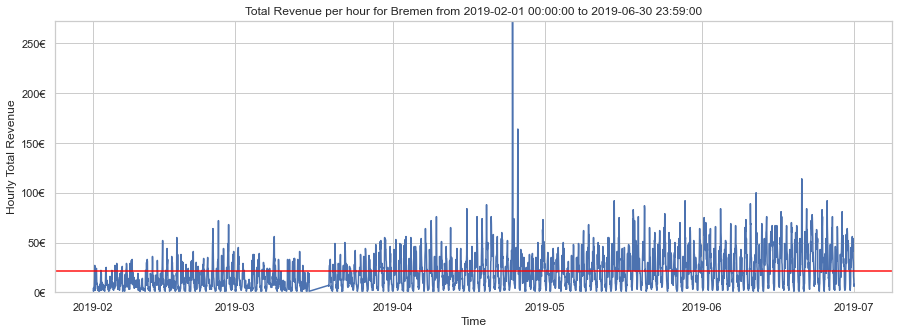

In [35]:
# create figure and axes
fig, (ax) = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))

# generate line plot
g = sns.lineplot(ax=ax, data=bremen.reset_index(), x="datetime", y="total_revenue", color='b', ci=None)
# draw line depicting the mean value
ax.axhline(y = bremen['total_revenue'].mean(), color='red', linewidth=2, alpha=.7)
# set title and axis labels
ax.set_title(f"Total Revenue per hour for {city1} from {startDate} to {endDate}")
ax.set_ylabel("Hourly Total Revenue")
ax.set_xlabel("Time")
# set axis scale limits
ax.set_ylim(yLimitHour)
# set yAxis € labels
yTickLabels = [str(int(y))+'€' for y in g.get_yticks()]
g.set_yticklabels(yTickLabels)

The fluctuation in hourly KPI values is very high. The hourly generated revenue in € varies between almost 0€ up to 50€ or more from February to April. Beginning with April, the revenue per hour varies between almost 0€ and up to 100€ with some spikes above 100€ per hour (around 25.04.19). Note, that around 19.03.19 there is a lack of data points, which could be explained by an error in the nextBike API.

The mean revenue per hour is around 21€, which is depicted by the red line.

Altogether, there is a positive trend of generated € per hour from february until end of june, which can be easily explained by higher number of trips and longer trips in time periods with higher temperature.

#### Bremen, daily
Here we can see the fluctuation of daily revenue over a long time interval, but with a lot less data points than the hourly plot. The variation of total revenue is better visible in this plot

[Text(0, 0, '0€'),
 Text(0, 0, '200€'),
 Text(0, 0, '400€'),
 Text(0, 0, '600€'),
 Text(0, 0, '800€'),
 Text(0, 0, '1000€'),
 Text(0, 0, '1200€')]

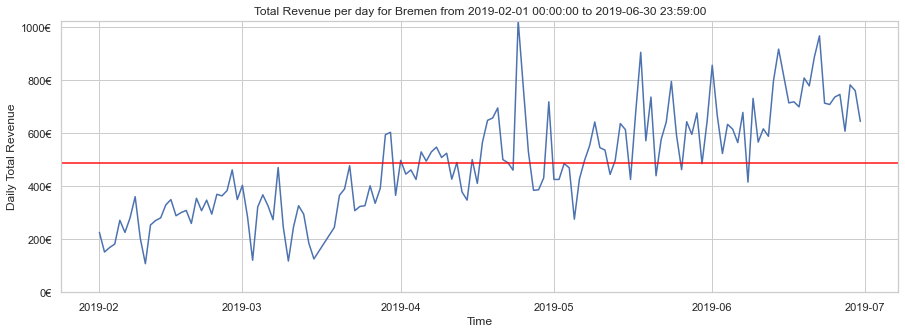

In [36]:
# create figure and axes
fig, (ax) = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))

g = sns.lineplot(ax=ax, data=bremen_gr_d, x="datetime", y="daily_total_revenue", color='b', ci=None)
ax.axhline(y = bremen_gr_d['daily_total_revenue'].mean(), color='red', linewidth=2, alpha=.7)
ax.set_title(f"Total Revenue per day for {city1} from {startDate} to {endDate}")
ax.set_ylabel("Daily Total Revenue")
ax.set_xlabel("Time")
ax.set_ylim(yLimitDay)
# set yAxis € labels
yTickLabels = [str(int(y))+'€' for y in g.get_yticks()]
g.set_yticklabels(yTickLabels)

The fluctuation in daily KPI values is also high. The daily generated revenue in € ranges from ~100€ up to ~1000€.

The mean revenue per hour is around 488€, which is depicted by the red line.

Altogether, there is a positive trend of generated € per hour from february until end of june, which can be easily explained by higher number of trips and longer trips in time periods with higher temperature as well.

#### Düsseldorf, hourly
We can see the fluctuation of hourly revenue over a very long time interval (6 months containing roughly 4460 hours, so we are plotting ~4460 KPI values).

[Text(0, 0, '0€'),
 Text(0, 0, '50€'),
 Text(0, 0, '100€'),
 Text(0, 0, '150€'),
 Text(0, 0, '200€'),
 Text(0, 0, '250€'),
 Text(0, 0, '300€')]

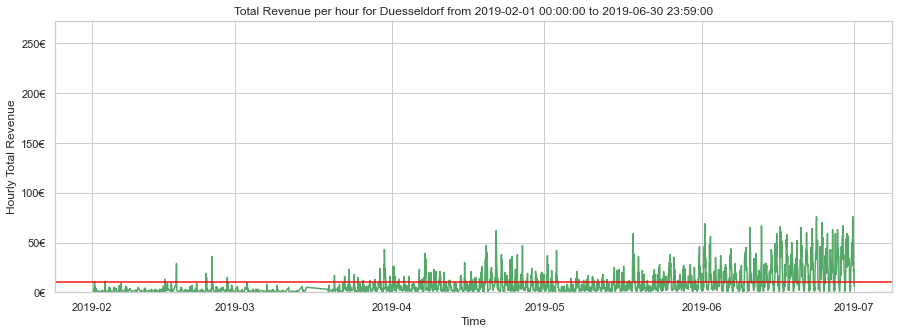

In [37]:
# create figure and axes
fig, (ax) = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))

# generate plots
g = sns.lineplot(ax=ax, data=duesseldorf.reset_index(), x="datetime", y="total_revenue", color='g', ci=None)
ax.axhline(y = duesseldorf['total_revenue'].mean(), color='red', linewidth=2, alpha=.7)
ax.set_title(f"Total Revenue per hour for {city2} from {startDate} to {endDate}")
ax.set_ylabel("Hourly Total Revenue")
ax.set_xlabel("Time")
ax.set_ylim(yLimitHour)
# set yAxis € labels
yTickLabels = [str(int(y))+'€' for y in g.get_yticks()]
g.set_yticklabels(yTickLabels)

The fluctuation in hourly KPI values is lower than in Bremen. The hourly generated revenue in € varies between almost 0€ up to 75€. Note, that around 19.03.19 there is also a lack of data points, which could be explained by an error in the nextBike API.

The mean revenue per hour is around 11€, which is depicted by the red line.

Altogether, there is a positive trend of generated € per hour from february until end of june, which can be easily explained by higher number of trips and longer trips in time periods with higher temperature.

#### Düsseldorf, Daily
Here we can see the fluctuation of daily revenue over a long time interval, but with a lot less data points than the hourly plot. The variation of total revenue is better visible in this plot

[Text(0, 0, '0€'),
 Text(0, 0, '200€'),
 Text(0, 0, '400€'),
 Text(0, 0, '600€'),
 Text(0, 0, '800€'),
 Text(0, 0, '1000€'),
 Text(0, 0, '1200€')]

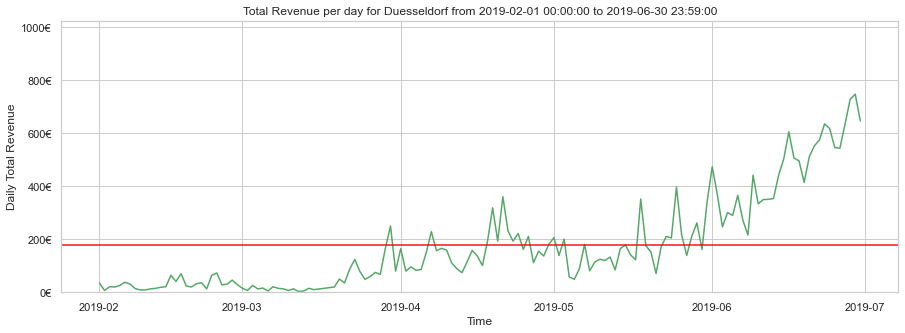

In [38]:
# create figure and axes
fig, (ax) = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))

# generate plots
g = sns.lineplot(ax=ax, data=duesseldorf_gr_d, x="datetime", y="daily_total_revenue", color='g', ci=None)
ax.axhline(y = duesseldorf_gr_d['daily_total_revenue'].mean(), color='red', linewidth=2, alpha=.7)
ax.set_title(f"Total Revenue per day for {city2} from {startDate} to {endDate}")
ax.set_ylabel("Daily Total Revenue")
ax.set_xlabel("Time")
ax.set_ylim(yLimitDay) # set y axis limit to maximum of daily values from bremen

# set yAxis € labels
yTickLabels = [str(int(y))+'€' for y in g.get_yticks()]
g.set_yticklabels(yTickLabels)

The fluctuation in daily KPI values over the whole time window is higher than in Bremen. The daily generated revenue in € ranges from ~0€ up to ~780€.

The mean revenue per hour is around 180€, which is depicted by the red line.

Altogether, there is a very strong positive trend of generated € per hour from february until end of june, which can be easily explained by higher number of trips and longer trips in time periods with higher temperature as well. But also one should note, that the trend seems disproportionately stronger than the plot of Bremen suggests, which asks for forther explanation

#### Both Cities, hourly
Here we can see the fluctuation of hourly revenue for both cities in comparison

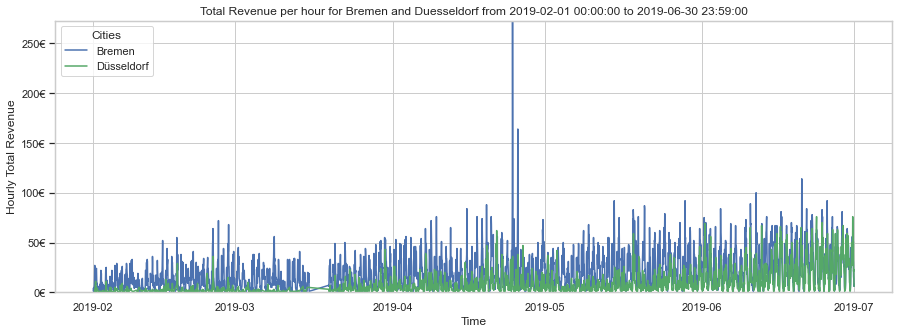

In [39]:
# generate figure
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,5))

# generate line plot
g = sns.lineplot(ax=ax, data=bremen.reset_index(), x="datetime", y="total_revenue", color='b', ci=None, label="Bremen")
ax.set_title(f"Total Revenue per hour for {city1} and {city2} from {startDate} to {endDate}")
ax.set_ylabel("Hourly Total Revenue")
ax.set_xlabel("Time")
ax.legend().set_visible(False) # removes a legend that would show up on the right side
ax.set_ylim(yLimitHour)
# set yAxis € labels
yTickLabels = [str(int(y))+'€' for y in g.get_yticks()]
g.set_yticklabels(yTickLabels)

# generate twin axis to show the values of duesseldorf on the same figure
ax2 = ax.twinx()

# generate second line plot
sns.lineplot(ax=ax2, data=duesseldorf.reset_index(), x="datetime", y="total_revenue", color='g', ci=None, label="Düsseldorf")
ax2.set_ylim(yLimitHour) 
ax2.yaxis.set_visible(False) # make second y-axis invisible

# set handles and labels for legend manually
handles,labels = [],[]
for ax in fig.axes:
    for h,l in zip(*ax.get_legend_handles_labels()):
        handles.append(h)
        labels.append(l)

plt.legend(handles,labels, loc="upper left", title="Cities")

##### Note: Both data sets show an irregularity around 2019-03-20, seems to be some kind of error in the provided data

#### Both Cities, daily
Here we can see the fluctuation of daily revenue for both cities in comparison

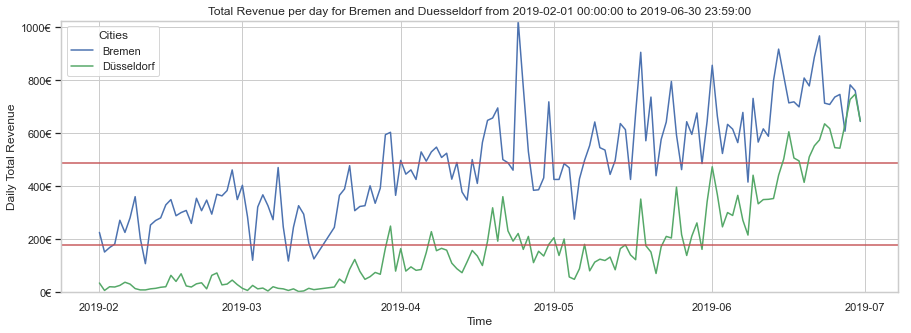

In [40]:
# generate figure
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,5))

# generate line plot
g = sns.lineplot(ax=ax, data=bremen_gr_d, x="datetime", y="daily_total_revenue", color='b', ci=None, label="Bremen")
# draw line depicting the mean value
ax.axhline(y = bremen_gr_d['daily_total_revenue'].mean(), color='r', linewidth=2, alpha=.7)
ax.set_title(f"Total Revenue per day for {city1} and {city2} from {startDate} to {endDate}")
ax.set_ylabel("Daily Total Revenue")
ax.set_xlabel("Time")
ax.set_ylim(yLimitDay)
ax.legend().set_visible(False) # removes a legend that would show up on the right side
# set yAxis € labels
yTickLabels = [str(int(y))+'€' for y in g.get_yticks()]
g.set_yticklabels(yTickLabels)


# generate twin axis
ax2 = ax.twinx()

# generate second line plot
sns.lineplot(ax=ax2, data=duesseldorf_gr_d, x="datetime", y="daily_total_revenue", color='g', ci=None, label="Düsseldorf")
# draw line depicting the mean value
ax2.axhline(y = duesseldorf_gr_d['daily_total_revenue'].mean(), color='r', linewidth=2, alpha=.7)
ax2.set_ylim(yLimitDay)
ax2.yaxis.set_visible(False)

# set handles and labels for legend manually
handles,labels = [],[]
for ax in fig.axes:
    for h,l in zip(*ax.get_legend_handles_labels()):
        handles.append(h)
        labels.append(l)

plt.legend(handles,labels, loc="upper left", title="Cities")

Here we can see that the generated revenue in Düsseldorf reaches the same level as the revenue generated in Bremen in late June.

### Total Revenue per Hour, averaged over the selected time interval and grouped over hours 0-24
Here, we are plotting the KPI values in the selected time frame grouped by Hours 0-24, grouped by weekdays and the totals for each month.

The first variant of plots is plotting the grouped absolute values, the second variant of plots is plotting the ratio of value/fleet size, grouped.

In [41]:
# setting limits for y-axis of the following plots by taking the minimum and maximum values of the grouped data for bremen
yLimit_gr_hourly = [0, bremen_gr_hourly["average_hourly_total_revenue"].max()]
yLimit_gr_weekday = [0, bremen_gr_weekday["average_weekday_total_revenue"].max()]
yLimit_gr_monthly = [0, bremen_gr_monthly["monthly_total_revenue"].max()]

yLimit_gr_hourly_w = [0, bremen_gr_hourly["average_hourly_total_revenue_w"].max()]
yLimit_gr_weekday_w = [0, bremen_gr_weekday["average_weekday_total_revenue_w"].max()]
yLimit_gr_monthly_w = [0, bremen_gr_monthly["monthly_total_revenue_w"].max()]

#### Bremen

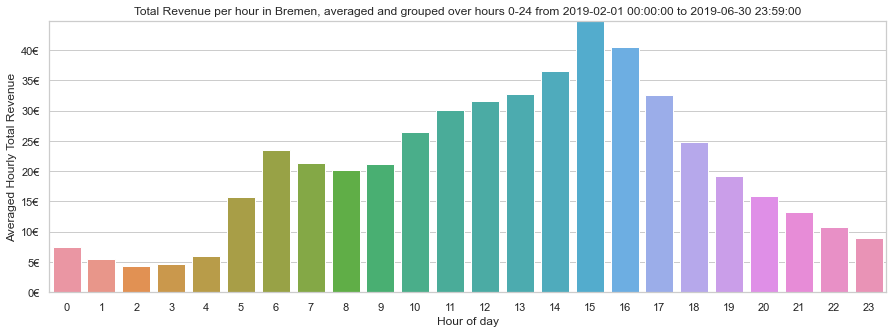

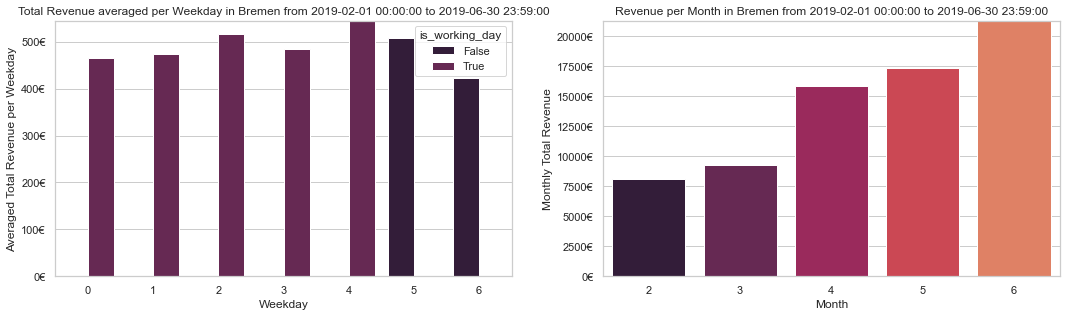

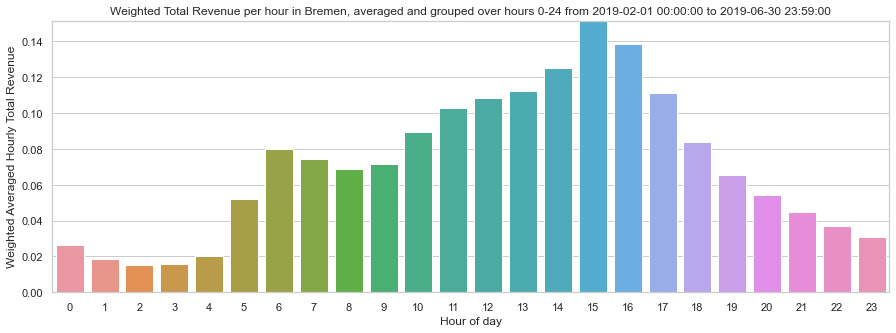

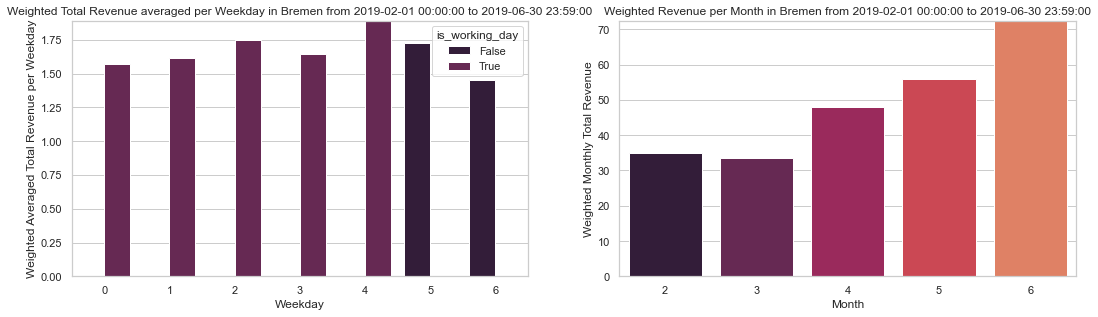

In [42]:
def tickLabels(g, weighted = False):
    # set yAxis € labels
    if not weighted:
        yTickLabels = [str(int(y))+'€' for y in g.get_yticks()]
        g.set_yticklabels(yTickLabels)

def createBarPlotsBremen(weighted=False):
    # create figure and axes for values grouped by hours 0-24
    fig, (ax) = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))

    # provide different columns and labelling depending on the 'weighted' param
    if not weighted:
        yColumns = ["average_hourly_total_revenue", "average_weekday_total_revenue", "monthly_total_revenue"]
    else: 
        yColumns = ["average_hourly_total_revenue_w", "average_weekday_total_revenue_w", "monthly_total_revenue_w"]
    ifWeighted = "Weighted " if weighted else ""
    
    g = sns.barplot(ax=ax, data=bremen_gr_hourly.reset_index(), x="hour", y=yColumns[0], ci=None)
    ax.set_title(f"{ifWeighted}Total Revenue per hour in {city1}, averaged and grouped over hours 0-24 from {startDate} to {endDate}")
    ax.set_ylabel(f"{ifWeighted}Averaged Hourly Total Revenue")
    ax.set_xlabel("Hour of day")
    ax.set_ylim(yLimit_gr_hourly_w if weighted else yLimit_gr_hourly)
    # set yAxis € labels
    tickLabels(g, weighted)

    # create figure and axes for values grouped by weekdays and for monthly total values
    fig2, (ax2, ax3) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    g2 = sns.barplot(ax=ax2, data=bremen_gr_weekday.reset_index(), x="weekday", y=yColumns[1], hue="is_working_day", ci=None)
    ax2.set_title(f"{ifWeighted}Total Revenue averaged per Weekday in {city1} from {startDate} to {endDate}")
    ax2.set_ylabel(f"{ifWeighted}Averaged Total Revenue per Weekday")
    ax2.set_xlabel("Weekday")
    ax2.set_ylim(yLimit_gr_weekday_w if weighted else yLimit_gr_weekday)
    # set yAxis € labels
    tickLabels(g2, weighted)

    g3 = sns.barplot(ax=ax3, data=bremen_gr_monthly.reset_index(), x="month", y=yColumns[2], ci=None)
    ax3.set_title(f"{ifWeighted}Revenue per Month in {city1} from {startDate} to {endDate}")
    ax3.set_ylabel(f"{ifWeighted}Monthly Total Revenue")
    ax3.set_xlabel("Month")
    ax3.set_ylim(yLimit_gr_monthly_w if weighted else yLimit_gr_monthly)
    # set yAxis € labels
    tickLabels(g3, weighted)

    fig2.subplots_adjust(left=0.05, right=0.98, top=0.96, bottom=0.25) # adjust spacing for overlapping plot titles
    
createBarPlotsBremen()
createBarPlotsBremen(weighted=True)

#### Düsseldorf

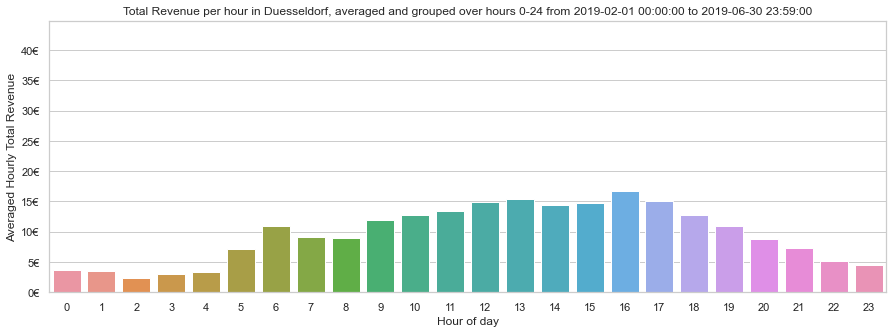

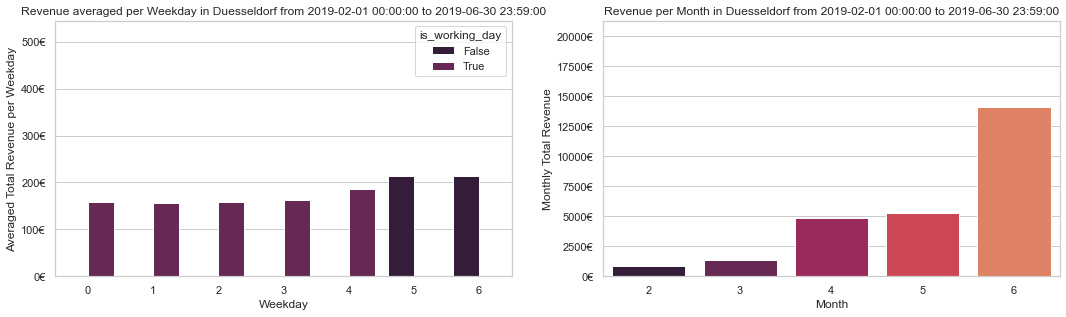

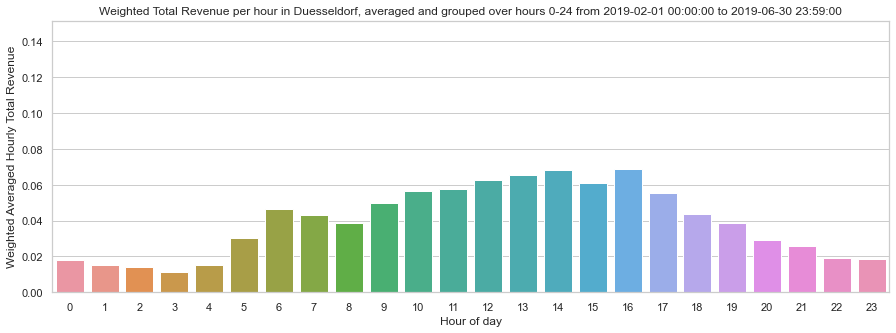

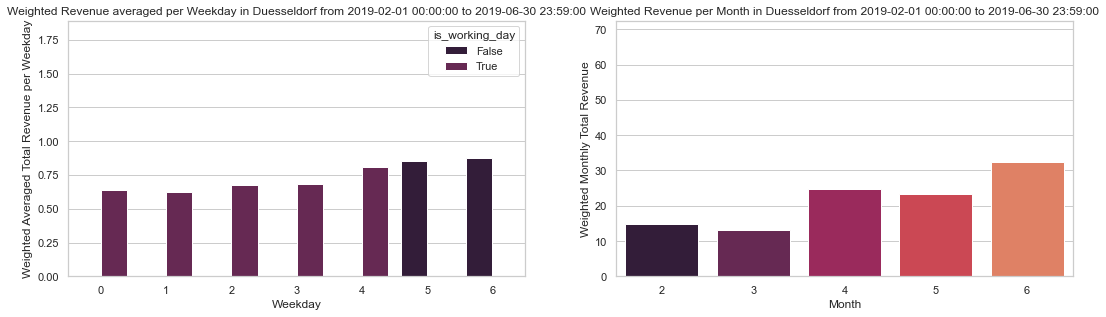

In [43]:
def tickLabels(g, weighted = False):
    # set yAxis € labels
    if not weighted:
        yTickLabels = [str(int(y))+'€' for y in g.get_yticks()]
        g.set_yticklabels(yTickLabels)

def createBarPlotsDuesseldorf(weighted=False):
    # create figure and axes for values grouped by hours 0-24
    fig, (ax) = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))

    # provide different columns and labelling depending on the 'weighted' param
    if not weighted:
        yColumns = ["average_hourly_total_revenue", "average_weekday_total_revenue", "monthly_total_revenue"]
    else: 
        yColumns = ["average_hourly_total_revenue_w", "average_weekday_total_revenue_w", "monthly_total_revenue_w"]
    ifWeighted = "Weighted " if weighted else ""
    
    g = sns.barplot(ax=ax, data=duesseldorf_gr_hourly.reset_index(), x="hour", y=yColumns[0], ci=None)
    ax.set_title(f"{ifWeighted}Total Revenue per hour in {city2}, averaged and grouped over hours 0-24 from {startDate} to {endDate}")
    ax.set_ylabel(f"{ifWeighted}Averaged Hourly Total Revenue")
    ax.set_xlabel("Hour of day")
    ax.set_ylim(yLimit_gr_hourly_w if weighted else yLimit_gr_hourly)
    tickLabels(g, weighted)
    
    # create figure and axes for values grouped by weekdays and for monthly total values
    fig2, (ax2, ax3) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    g2 = sns.barplot(ax=ax2, data=duesseldorf_gr_weekday.reset_index(), x="weekday", y=yColumns[1], hue="is_working_day", ci=None)
    ax2.set_title(f"{ifWeighted}Revenue averaged per Weekday in {city2} from {startDate} to {endDate}")
    ax2.set_ylabel(f"{ifWeighted}Averaged Total Revenue per Weekday")
    ax2.set_xlabel("Weekday")
    ax2.set_ylim(yLimit_gr_weekday_w if weighted else yLimit_gr_weekday)
    tickLabels(g2, weighted)
    
    g3 = sns.barplot(ax=ax3, data=duesseldorf_gr_monthly.reset_index(), x="month", y=yColumns[2], ci=None)
    ax3.set_title(f"{ifWeighted}Revenue per Month in {city2} from {startDate} to {endDate}")
    ax3.set_ylabel(f"{ifWeighted}Monthly Total Revenue")
    ax3.set_xlabel("Month")
    ax3.set_ylim(yLimit_gr_monthly_w if weighted else yLimit_gr_monthly)
    tickLabels(g3, weighted)
    
    fig2.subplots_adjust(left=0.05, right=0.98, top=0.96, bottom=0.25) # adjust spacing for overlapping plot titles
    
createBarPlotsDuesseldorf()
createBarPlotsDuesseldorf(weighted=True)

# KPI 1: Utilisation rate

* monthly
* daily
* hourly

### The utilisation rate is calculated for an average bike on an average day.
Because of the size changes in the available bike fleet, especially in the Duesseldorf data-set, the average is calculated with the fleetsizes in mind. 

$\ avg. fleetsize =  \sum_{k=1}^{no. rentals} \frac{1}{fleetsize * days} $
#### Fleetsize:
The fleetsize is approximated on a weekly basis. It is calculated on the assumption that most bikes will be rented at least once during one whole week. The number of unique ids that are rented in that time period is used to approximate the current fleetsize of every trip




### Data Plotting def:

In [44]:
def get_timeperiod(mode):
    return mode["day"].nunique()
    
def set_number_of_columns(timeresolution):  
    if timeresolution == "weekday":
        numberof_columns = 7
    if timeresolution == "hour":
        numberof_columns = 24    
    if timeresolution == "month":
        numberof_columns =  5  
    return numberof_columns


def set_utilisation(df, timeresolution):
    number_of_days = get_timeperiod(df)
    numberof_columns = set_number_of_columns(timeresolution)              
    bike_usage = df
    bike_usage["utilisation"] = bike_usage["fleetsize_weekly"].apply(lambda x: (numberof_columns) / ( number_of_days ))
    bike_utilisation= bike_usage.groupby(timeresolution, as_index= True )["utilisation"].sum().reset_index()
    return bike_utilisation
    return bike_usage

def set_utilisation_ratio(df, timeresolution):
    number_of_days = get_timeperiod(df)
    numberof_columns = set_number_of_columns(timeresolution)              
    bike_usage = df
        # TO_DO berechnung überprüfen
    bike_usage["utilisation"] = bike_usage["fleetsize_weekly"].apply(lambda x: (numberof_columns) / (x * number_of_days ))
    bike_utilisation= bike_usage.groupby(timeresolution, as_index= True )["utilisation"].sum().reset_index()
    return bike_utilisation



def general_utilisation(city_name,lable,provider,dataset,ratio):
    mode = read_data(city_name)


    if ratio == "absolute":
        # differnt temporal_resolutions
        df_hour = set_utilisation (mode, "hour")
        df_weekday = set_utilisation (mode, "weekday")
        df_month = set_utilisation (mode, "month")
      
    if ratio == "compensated":
        # differnt temporal_resolutions
        df_hour = set_utilisation_ratio (mode, "hour")
        df_weekday = set_utilisation_ratio (mode, "weekday")
        df_month = set_utilisation_ratio (mode, "month")
    
    # plots
    fig1, (ax1) = plt.subplots(1, 1, figsize=(15,5))
    fig2, (ax2, ax3) = plt.subplots(1, 2, figsize=(15,5))

    sns.barplot(x="hour", y="utilisation", data=df_hour, palette="rocket", ax=ax1)
    sns.barplot(x="weekday", y="utilisation", data=df_weekday, palette="rocket", ax=ax2)
    sns.barplot(x="month", y="utilisation", data=df_month, palette="rocket", ax=ax3) 
    
    # add mean utilisation line to plot
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=40, ha="right")
    ax1.axhline(y = df_hour['utilisation'].mean(), color='red', linewidth=2, alpha=.7)
    ax1.set(xlabel='Hours', ylabel="Average "+lable+" utilisation")
    ax1.set_title(provider+": Average "+lable+" utilisation per hour")

    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=40, ha="right")
    ax2.axhline(y = df_weekday['utilisation'].mean(), color='red', linewidth=2, alpha=.7)
    ax2.set(xlabel='Weekdays', ylabel="Average "+lable+" utilisation")
    ax2.set_title(provider+": Average "+lable+" utilisation per weekday")

    ax3.set_xticklabels(ax3.get_xticklabels(), rotation=40, ha="right")
    ax3.axhline(y = df_month['utilisation'].mean(), color='red', linewidth=2, alpha=.7)
    ax3.set(xlabel='Month', ylabel="Average "+lable+" utilisation")
    ax3.set_title(provider+": Average "+lable+" utilisation per month" ) 
    
    
#    fig1.savefig("Test_Pictures/general_utilisation_hour_"+provider+"_"+lable+"_"+dataset+".pdf")
#    fig2.savefig("Test_Pictures/general_utilisation_month&weekday_"+provider+"_"+lable+"_"+dataset+".pdf")

    fig1.tight_layout()
    fig2.tight_layout()
    return 

# Utilization rate plots Duesseldorf:

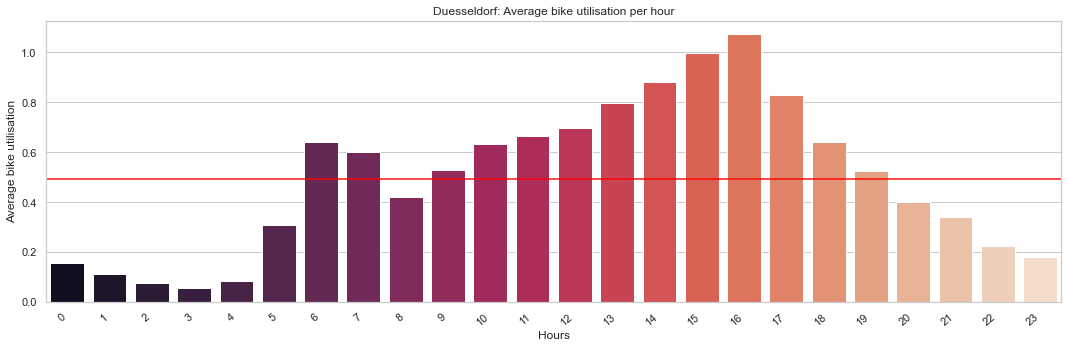

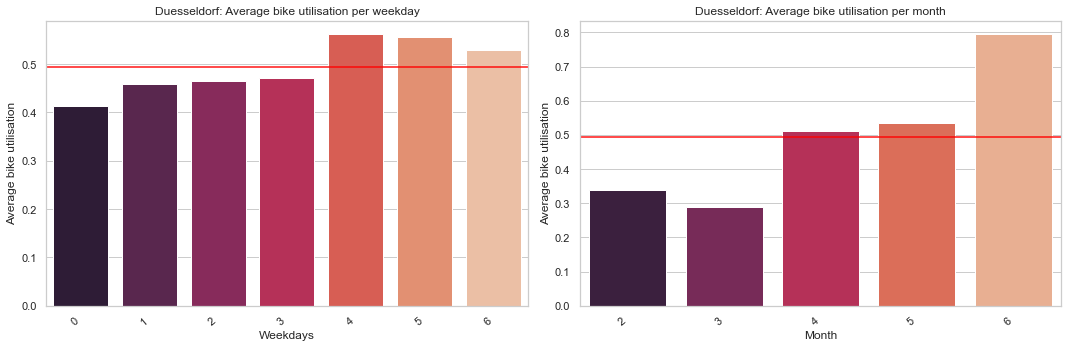

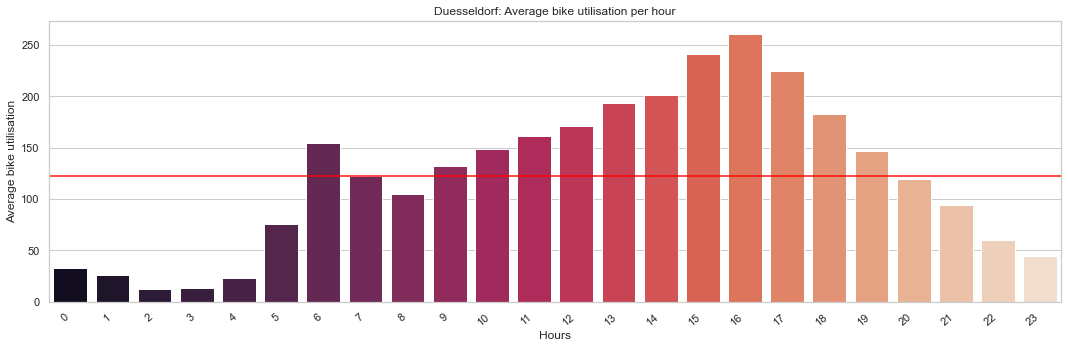

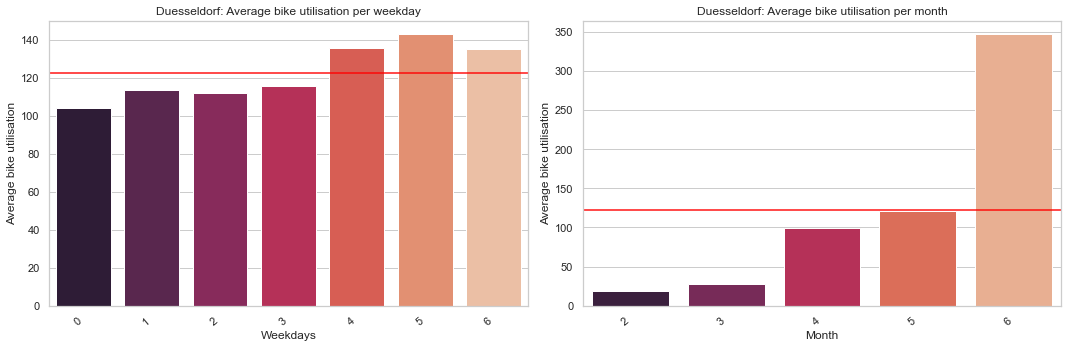

In [45]:
general_utilisation("duesseldorf","bike","Duesseldorf","dataset","compensated")
general_utilisation("duesseldorf","bike","Duesseldorf","dataset","absolute")

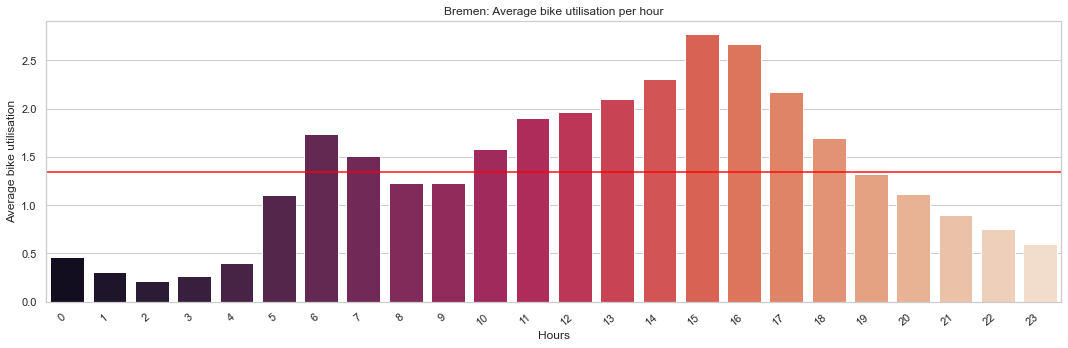

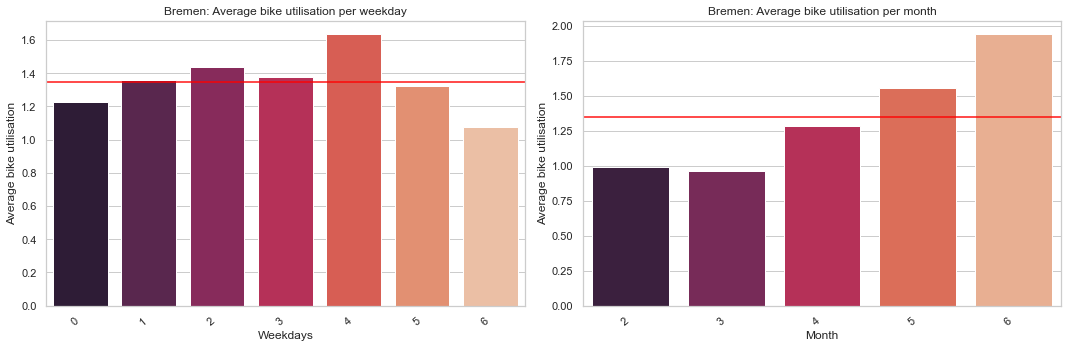

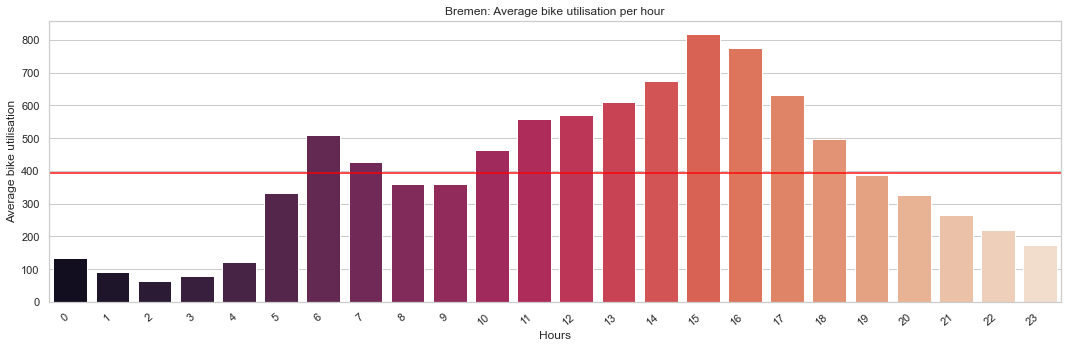

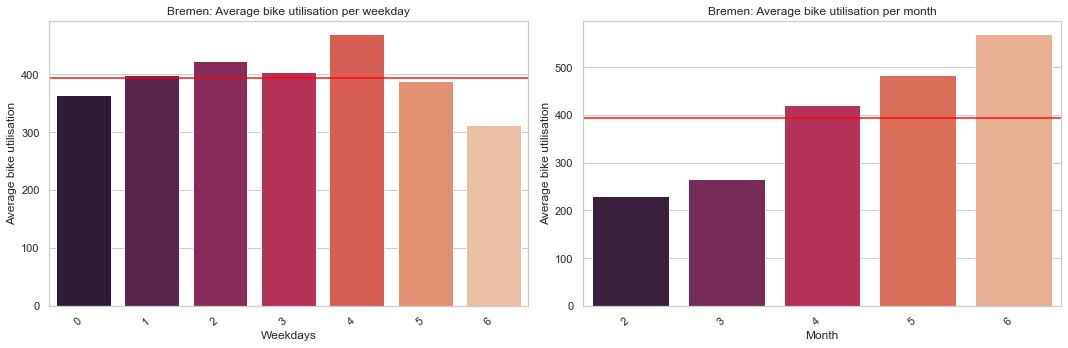

In [46]:

general_utilisation("bremen","bike","Bremen","dataset","compensated")
general_utilisation("bremen","bike","Bremen","dataset","absolute")


In [47]:
def plot_weather_overview(city_name,weather):   
    fig,ax = plt.subplots(figsize=(15,5), dpi= 80)
    data = read_data(city_name)
    test = pd.DataFrame(data.groupby(data["day"])[weather].mean())
    ax.plot(test.index,test[weather] )
    ax.set_xlabel("time")
    ax.set_ylabel(weather)
    ax.set_title(weather+" overview " )
#    plt.savefig("Project_Data/Graphics"+city+"_"+".pdf")
    plt.show()

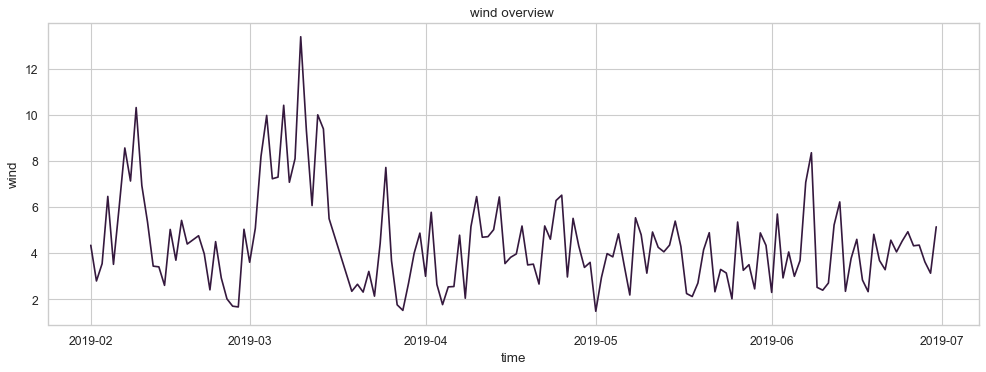

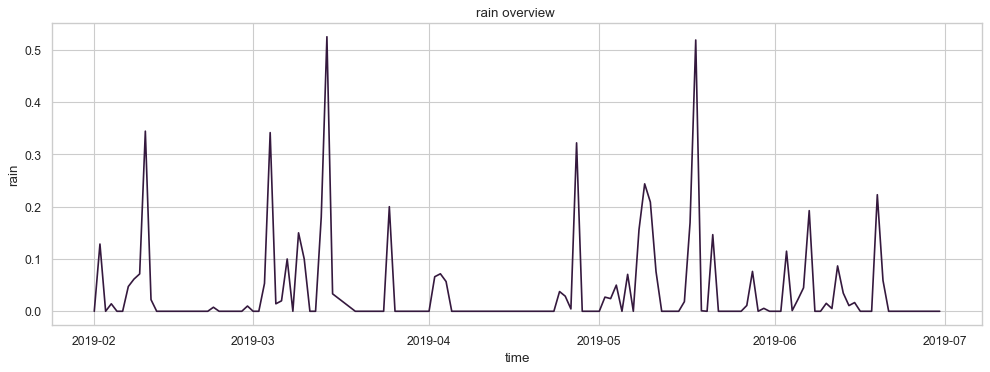

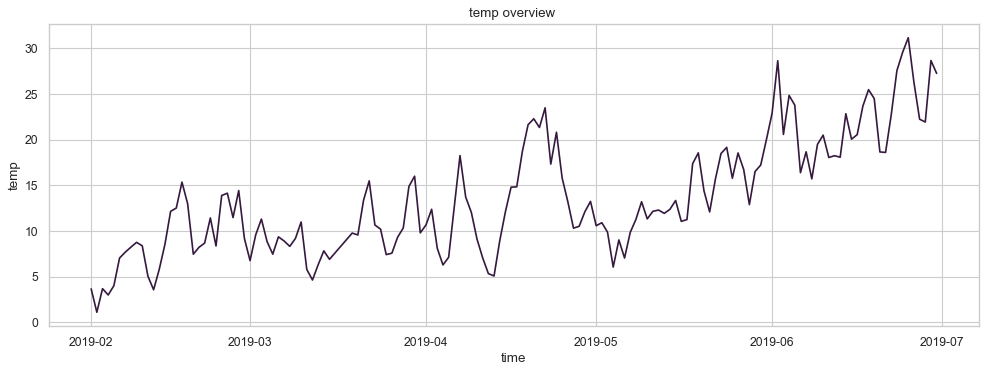

In [48]:
plot_weather_overview("duesseldorf","wind")
plot_weather_overview("duesseldorf","rain")
plot_weather_overview("duesseldorf","temp")

In [49]:
def plot_b_number_overview(city_name):   
    fig,ax = plt.subplots(figsize=(15,5), dpi= 80)
    data = read_data(city_name)
    
    test = pd.DataFrame(data.groupby(data["b_number"])["day"].count())
    test = test.sort_values("day")
    test = test.reset_index(drop=True)
    ax.plot(test.index,test["day"] )
    ax.set_xlabel("b_number")
    ax.set_ylabel("# rentals")
    ax.set_title(" overview " )
#    plt.savefig("Project_Data/Graphics"+city+"_"+".pdf")
    plt.show()

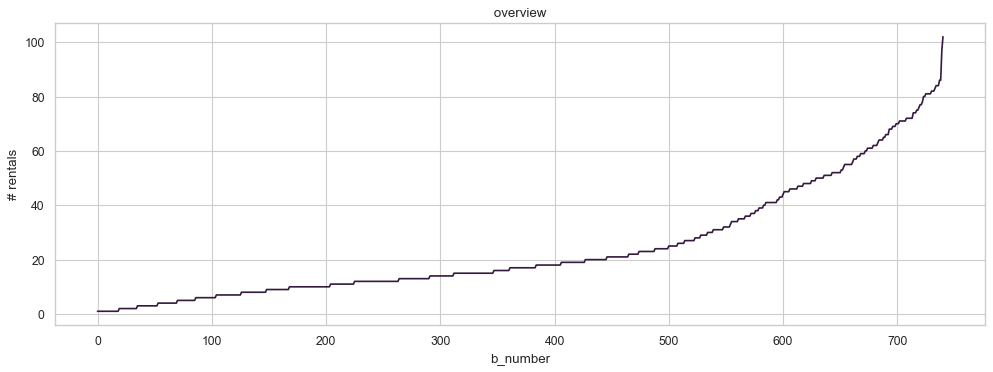

In [50]:
te = plot_b_number_overview("duesseldorf")